In [1]:
import numpy as np
import pandas as pd
import time
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [2]:
times = {}

def timed(fn):
    def inner(A, B, dtype):
        start = time.perf_counter()
        x = fn(A.astype(dtype), B.astype(dtype), dtype)
        dt = time.perf_counter() - start
        name = f"{dtype.__name__}"
        n = A.shape[0]
        times.setdefault(name, {})[n] = dt
        return x
    return inner

In [3]:
@timed
def gauss_elim(A, B, dtype):
    n = A.shape[0]
    AB = np.hstack((A.copy(), B.reshape(-1,1)))
    for i in range(n):
        maxr = np.argmax(np.abs(AB[i:, i])) + i
        if AB[maxr, i] == 0:
            raise np.linalg.LinAlgError("Zero pivot")
        if maxr != i:
            AB[[i, maxr]] = AB[[maxr, i]]
        AB[i] = AB[i] / AB[i, i]
        for j in range(i+1, n):
            AB[j] -= AB[j, i] * AB[i]
    x = np.zeros(n, dtype=dtype)
    for i in range(n-1, -1, -1):
        x[i] = AB[i, -1] - np.dot(AB[i, i+1:n], x[i+1:n])
    return x

In [4]:
def make_A1(n, dtype):
    A = np.zeros((n,n), dtype=dtype)
    for i in range(n):
        for j in range(n):
            A[i,j] = 1.0 if i==1 else 1.0/( (i+1)+(j+1)-1 )
    return A

def make_A2(n, dtype):
    A = np.zeros((n,n), dtype=dtype)
    for i in range(n):
        for j in range(n):
            if j >= i:
                A[i,j] = 2.0*(i+1)/(j+1)
            else:
                A[i,j] = 2.0*(j+1)/(i+1)
    return A

In [5]:
def run_task(matrix_fn, n_values):
    records = []
    for n in n_values:
        for dtype in (np.float32, np.float64):

            A = matrix_fn(n, dtype)
            x_true = np.random.choice([1., -1.], size=n).astype(dtype)
            b = A.dot(x_true)

            try:
                x_calc = gauss_elim(A, b, dtype)
            except Exception:
                err_inf = np.nan
                err_2   = np.nan
            else:
                err_inf = norm(x_true - x_calc, ord=np.inf)
                err_2   = norm(x_true - x_calc, ord=2)

            try:
                cond = np.linalg.norm(A, np.inf) * np.linalg.norm(np.linalg.inv(A), np.inf)
            except Exception:
                cond = np.nan

            t = times[dtype.__name__].get(n, np.nan)
            records.append({
                'n': n,
                'dtype': dtype.__name__,
                'err_inf': err_inf,
                'err_2': err_2,
                'time_s': t,
                'cond_1': cond
            })
    return pd.DataFrame.from_records(records)

In [6]:
if __name__ == '__main__':
    np.random.seed(0)

    ns1 = range(2, 101)
    df1 = run_task(make_A1, ns1)

    ns2 = list(range(2,101)) + list(range(110, 501, 10))
    df2 = run_task(make_A2, ns2)

    def pivot_wide(df):
        wide = df.pivot(index='n', columns='dtype')

        wide.columns = [f"{metric}_{dtype}" for (metric, dtype) in wide.columns]
        wide = wide.reset_index()
        return wide

    wide1 = pivot_wide(df1)
    wide2 = pivot_wide(df2)

    wide1.to_csv('task1_results_wide.csv', index=False)
    wide2.to_csv('task2_results_wide.csv', index=False)
   

In [7]:
from matplotlib.ticker import MaxNLocator

if __name__ == '__main__':
    title_map = {
            'err_inf': ('Maksymalny błąd', 'Wartość maksymalnego błędu ‖x_true–x_calc‖'),
            'err_2'  : ('Błąd euklidesowy',      'Wartość błędu euklidesowego ‖x_true–x_calc‖'),
            'time_s' : ('Czas obliczeń',         'Czas wykonania algorytmu [s]'),
            'cond_1' : ('Współcz. uwarunkowania', 'Cond(A) = ‖A‖·‖A⁻¹‖')
    }

    def plot_with_range(wide, metric, scale, n_min, n_max):
        df = wide[(wide['n'] >= n_min) & (wide['n'] <= n_max)]
        
        plt.figure(figsize=(10,6))
        x = df['n']
        plt.scatter(x, df[f"{metric}_float32"], marker='o', s=10, label='float32')
        plt.scatter(x, df[f"{metric}_float64"], marker='o', s=10, label='float64')
        if scale == 'log':
            plt.yscale('log')
        main_title, y_label = title_map[metric]
        plt.title(
            f"{main_title} – skala {'logarytmiczna' if scale=='log' else 'liniowa'} "
            f"(zakres n={n_min}–{n_max})"
        )
        plt.xlabel('Rozmiar macierzy n')
        plt.ylabel(y_label)
        plt.legend()
        # plt.ylim(top=50)
        # plt.ylim(bottom=-1)
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        
        plt.tight_layout()
        plt.show()


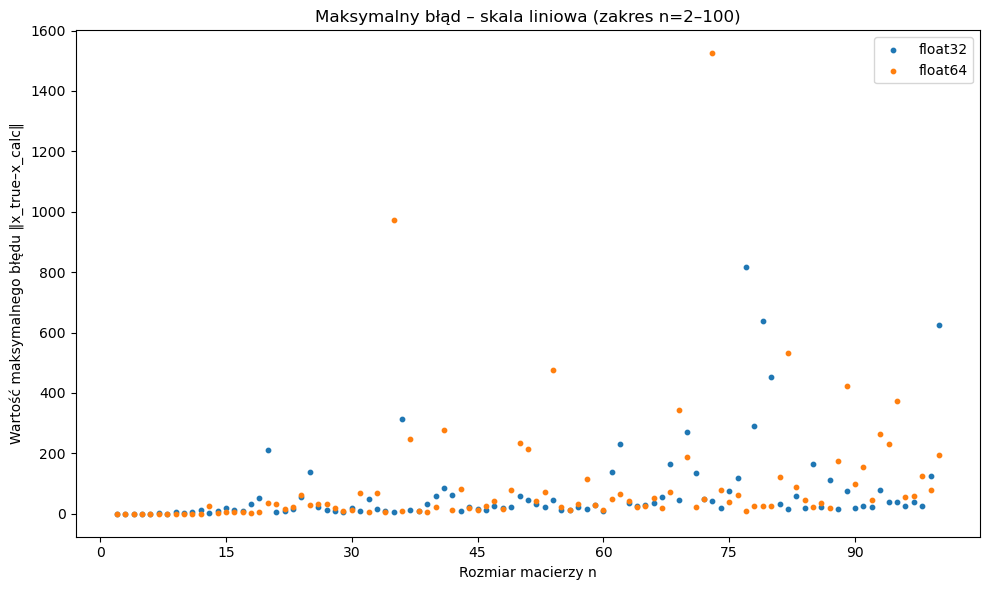

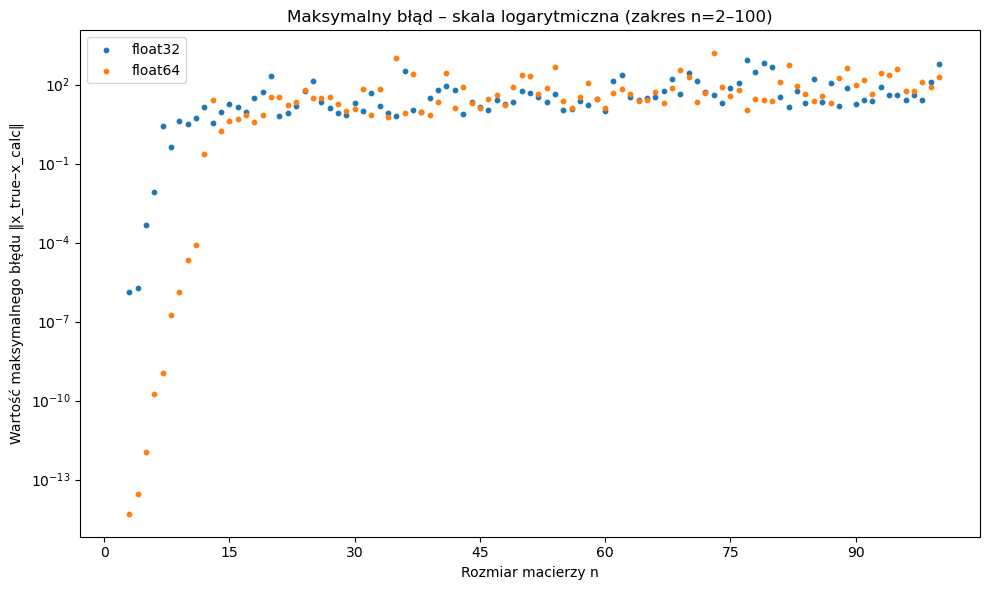

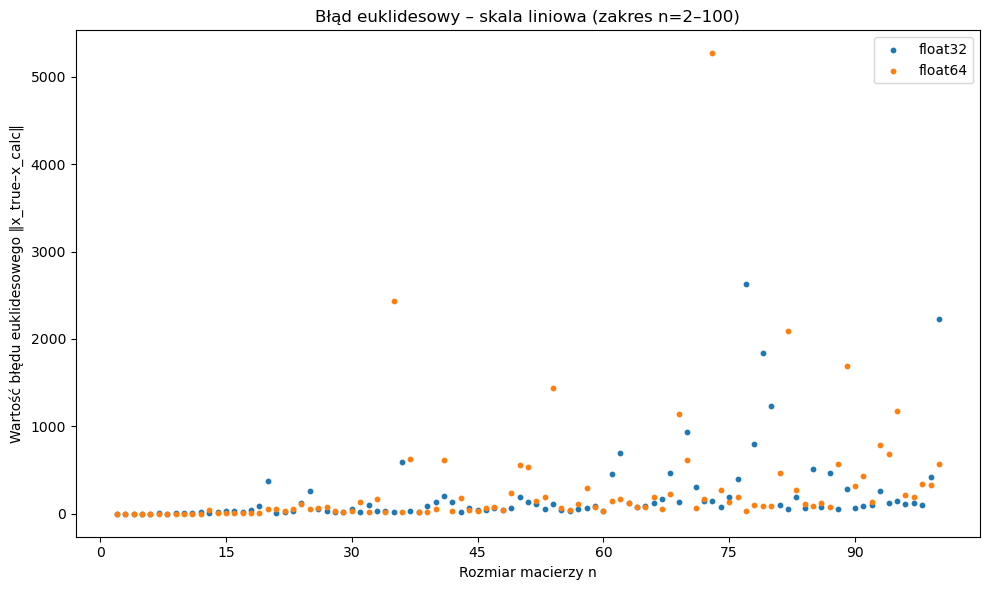

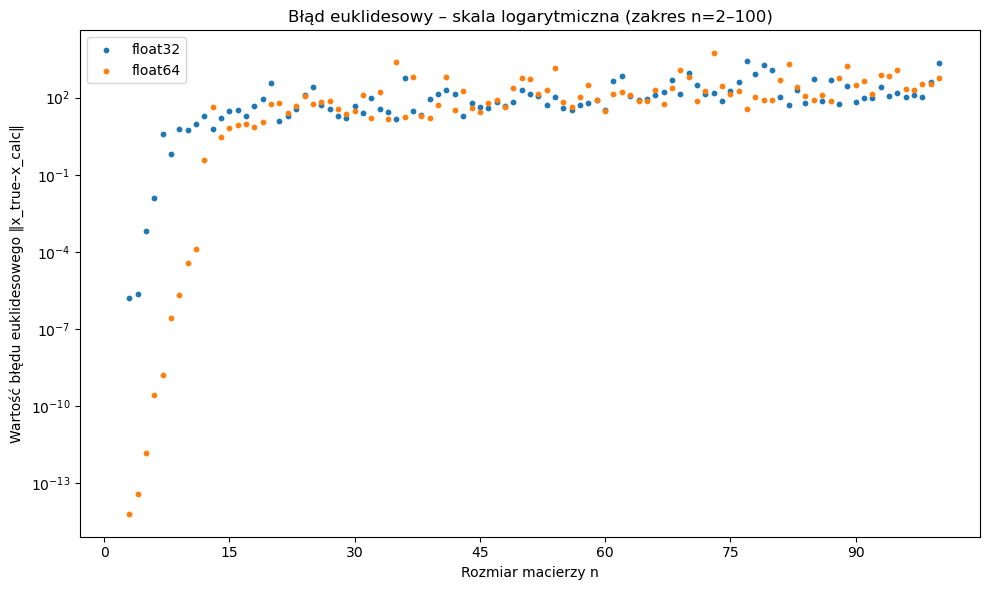

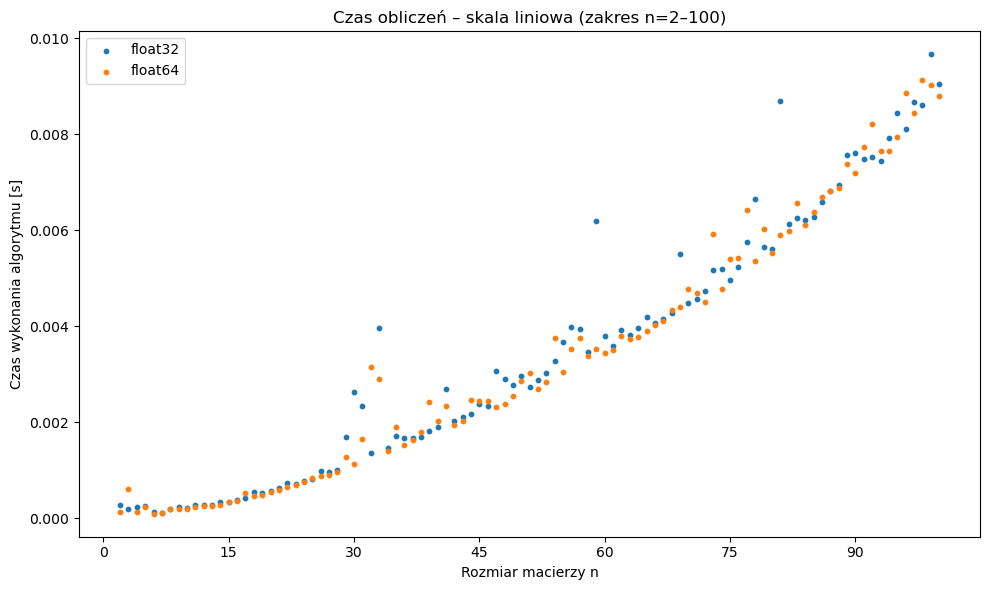

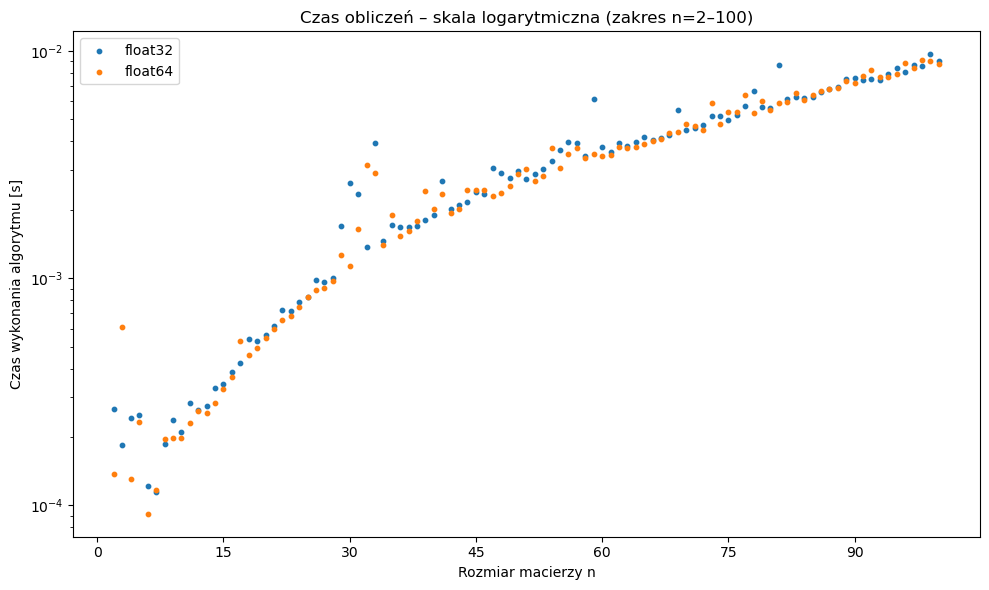

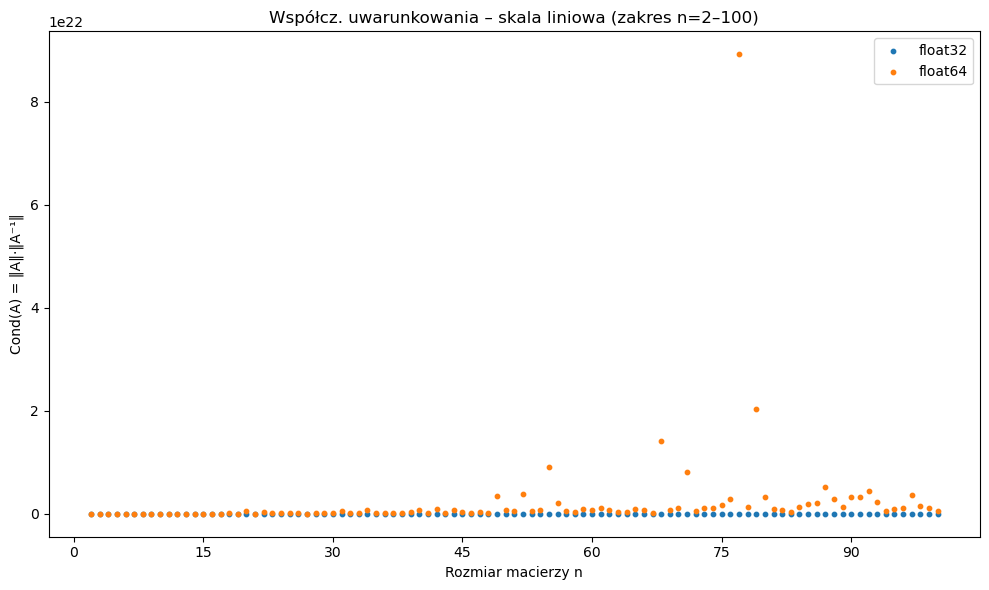

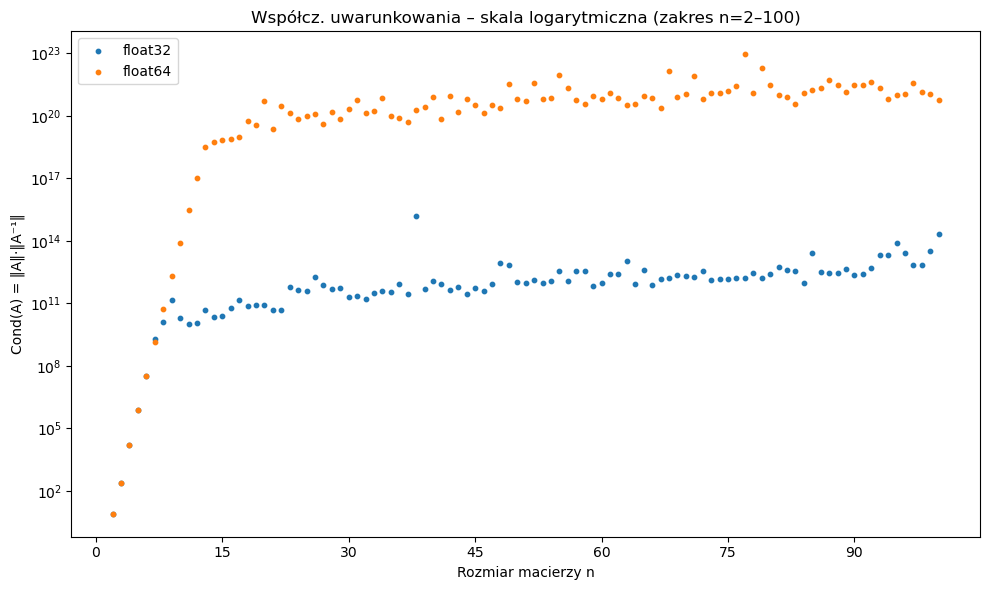

In [8]:
for metric in title_map:
    plot_with_range(wide1, metric, scale='linear', n_min=2, n_max=100)
    plot_with_range(wide1, metric, scale='log',    n_min=2, n_max=100)

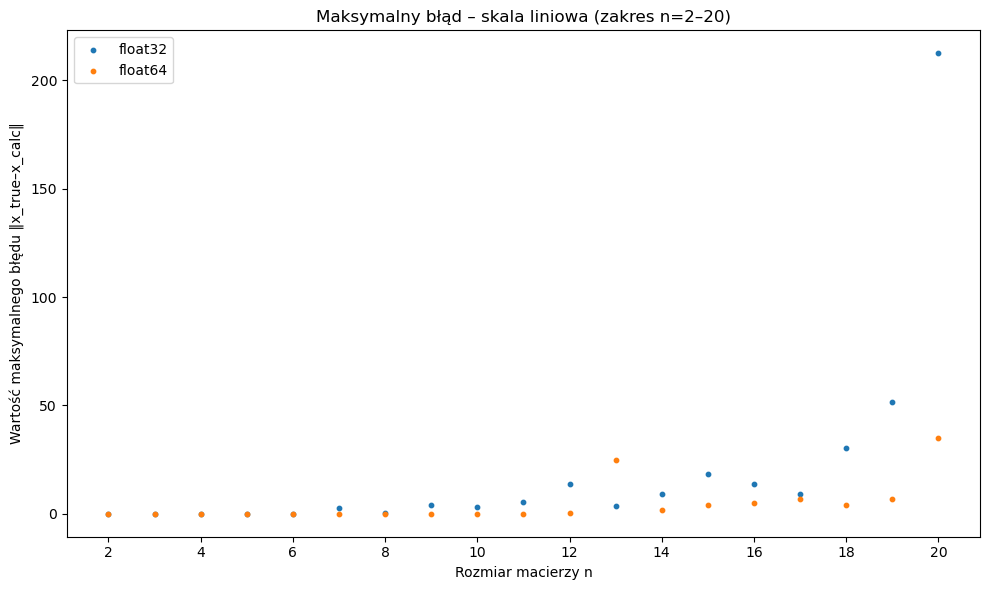

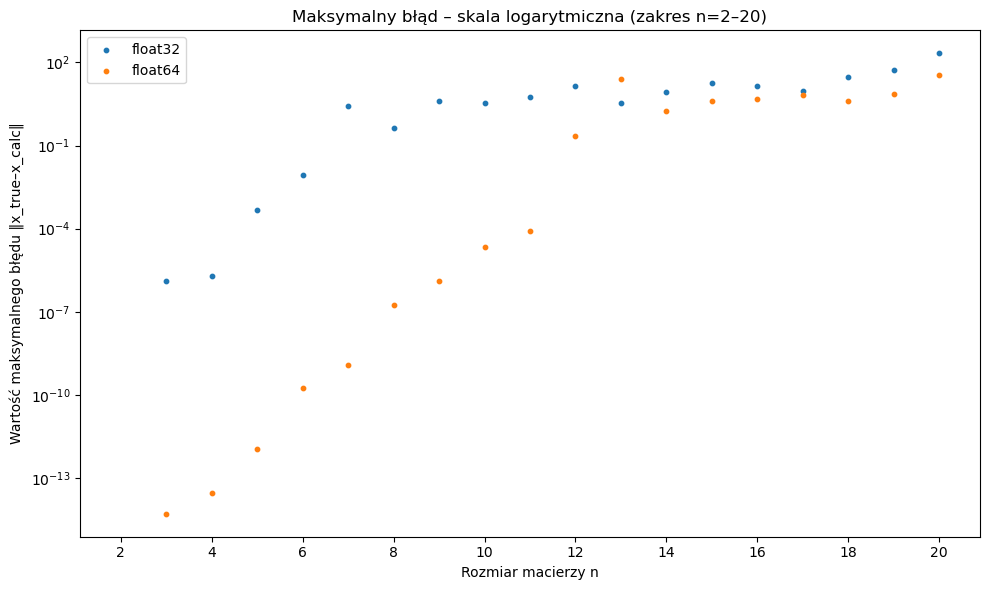

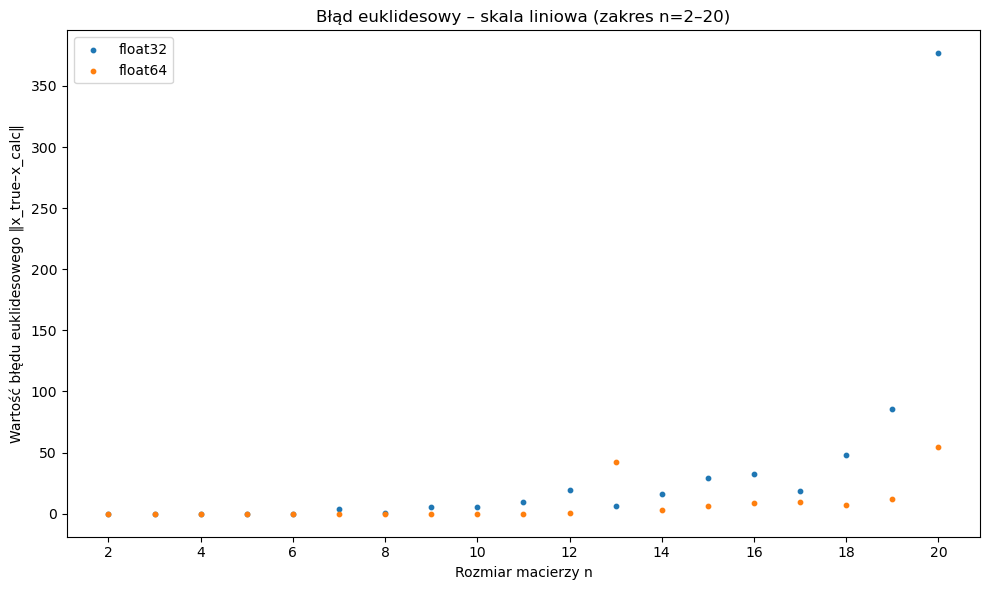

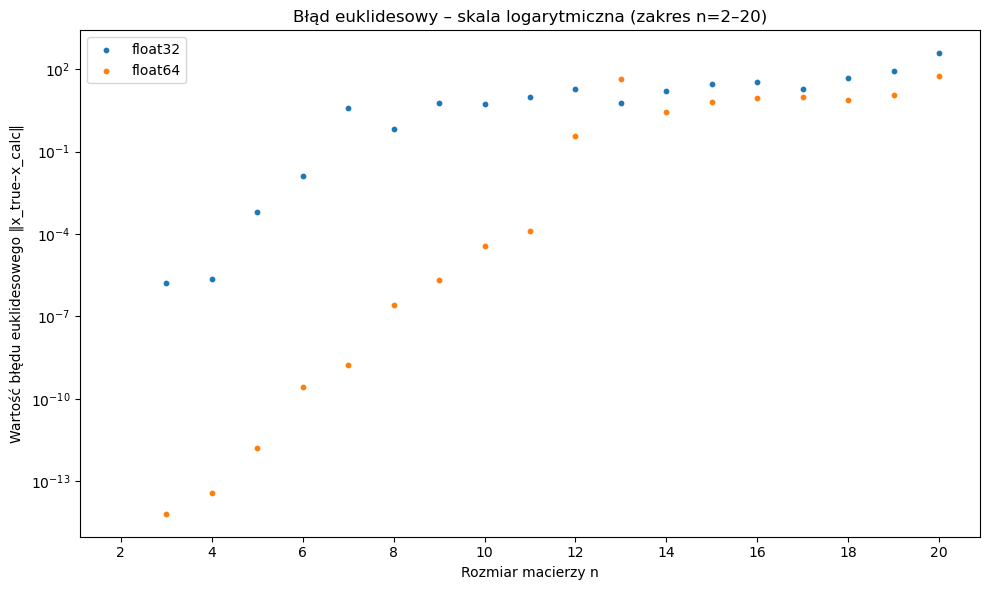

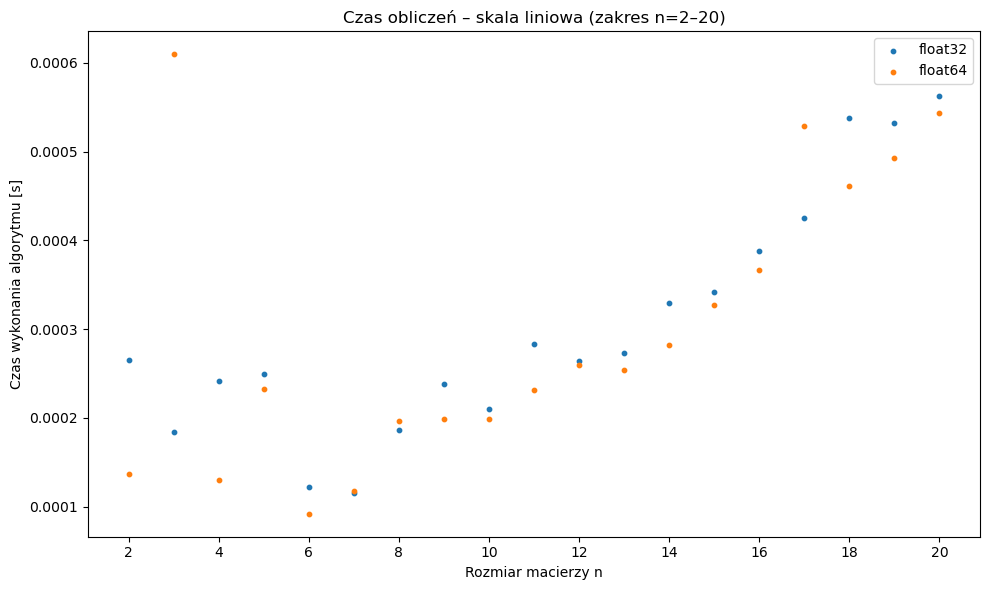

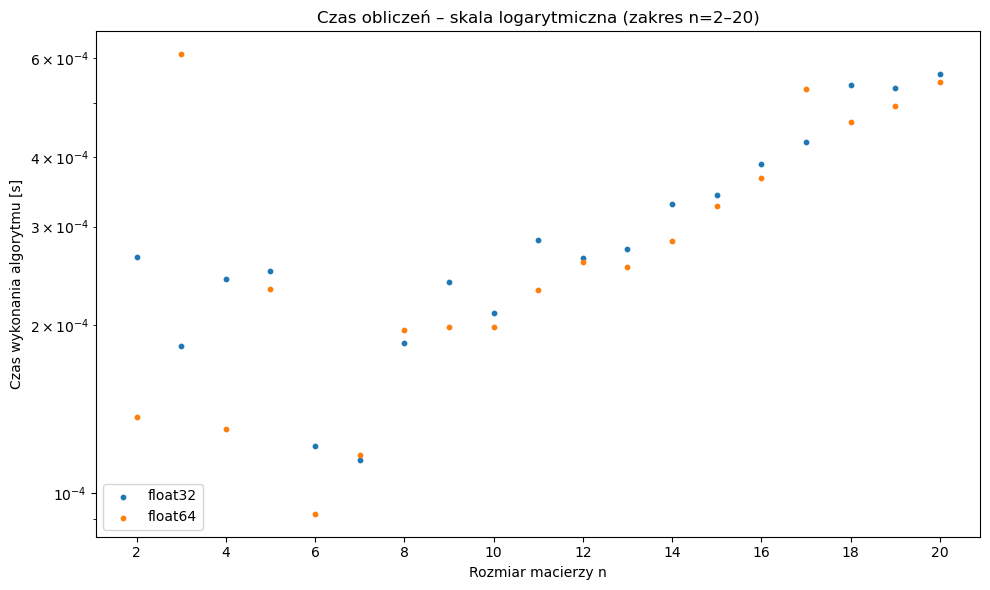

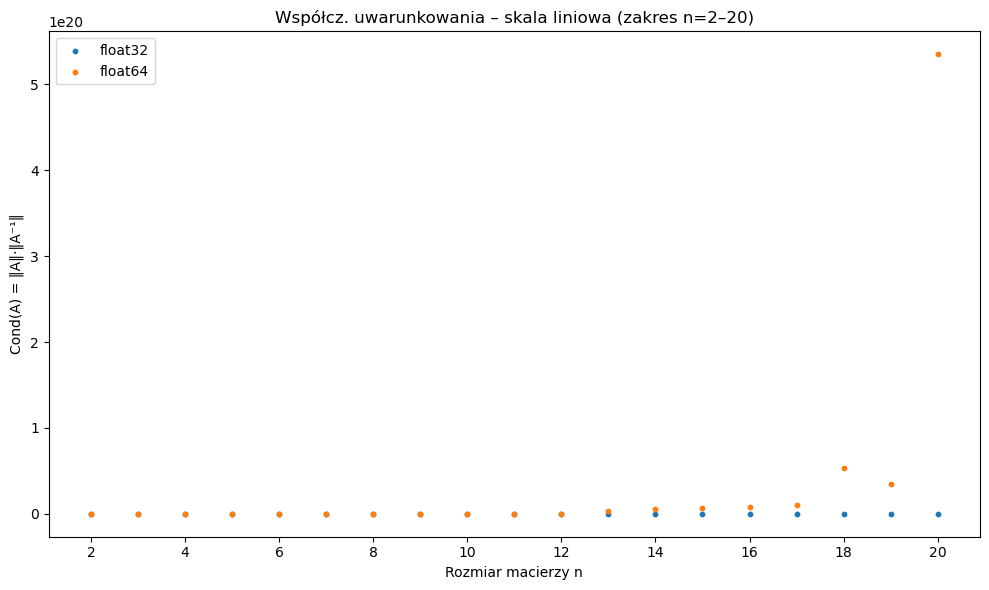

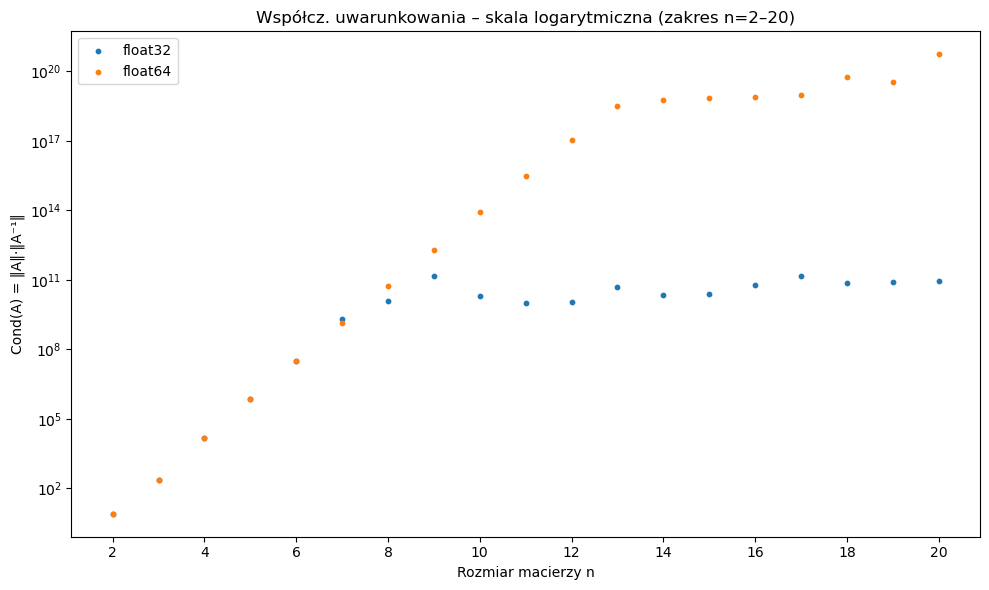

In [9]:
for metric in title_map:
    plot_with_range(wide1, metric, scale='linear', n_min=2, n_max=20)
    plot_with_range(wide1, metric, scale='log',    n_min=2, n_max=20)

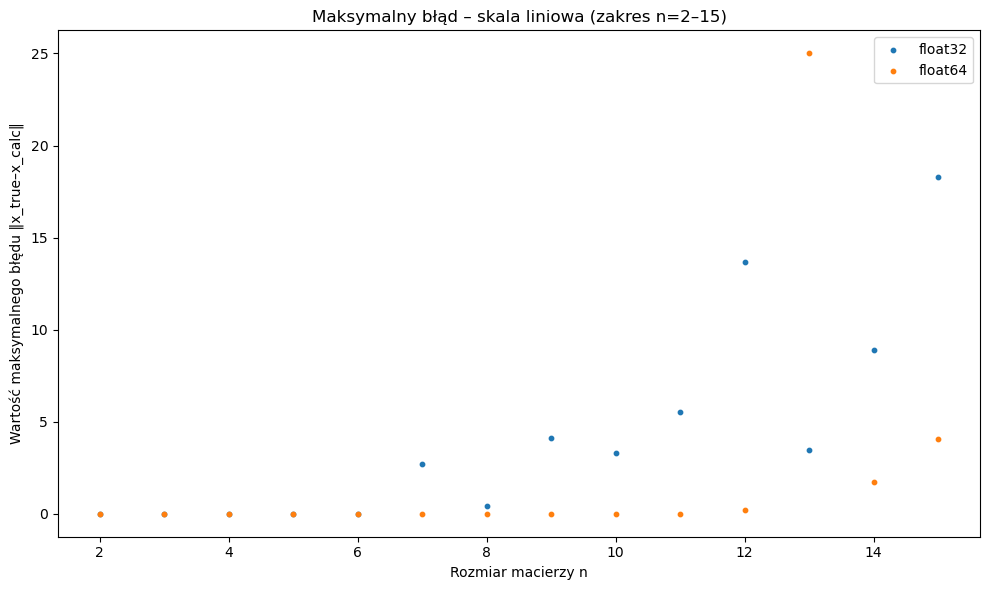

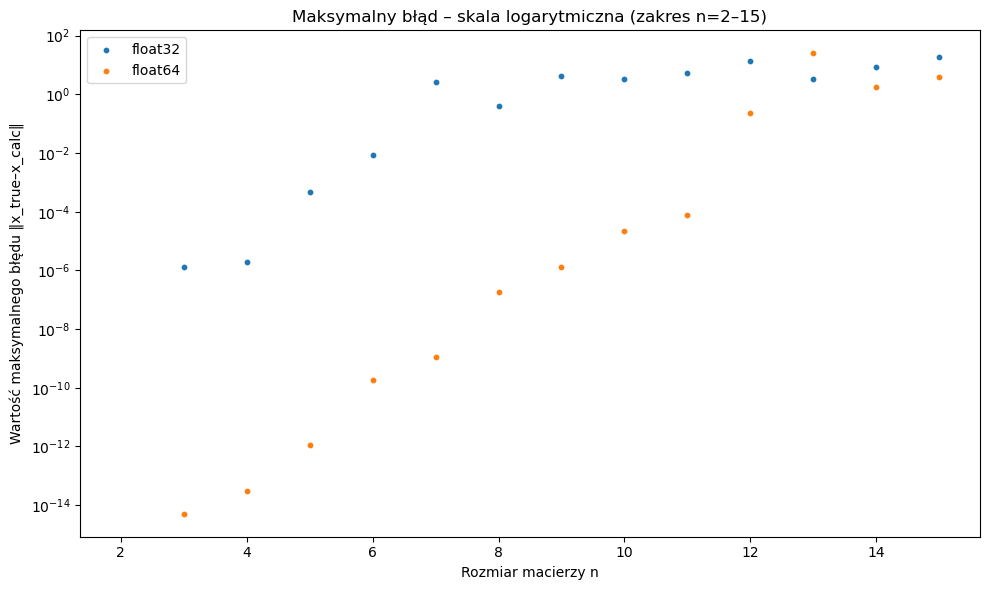

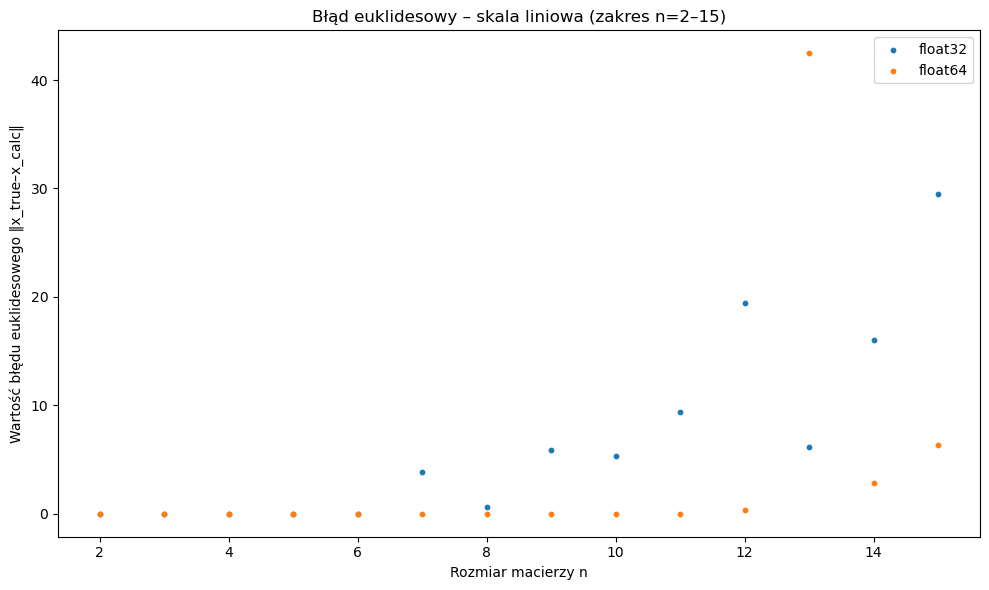

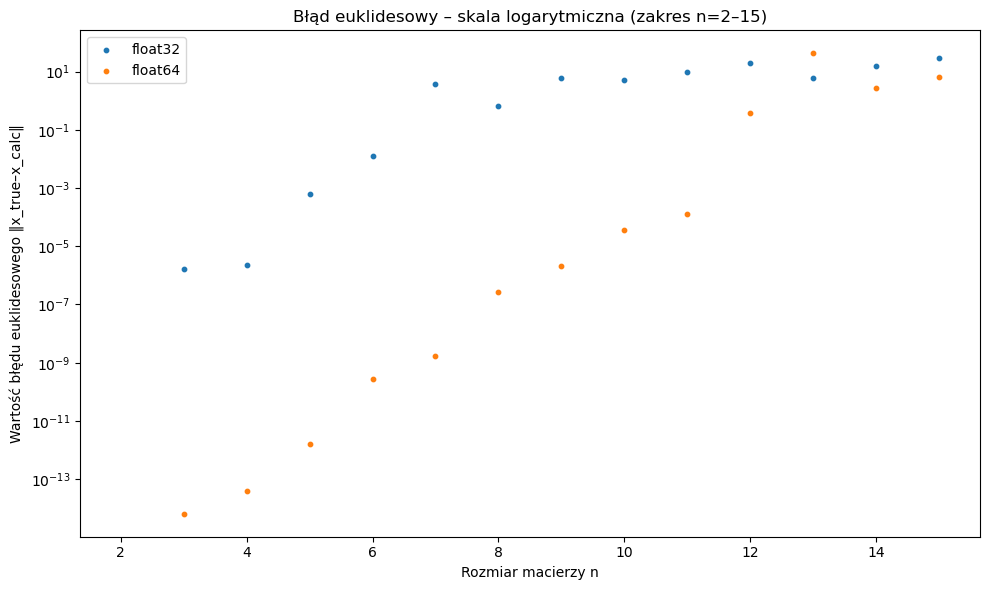

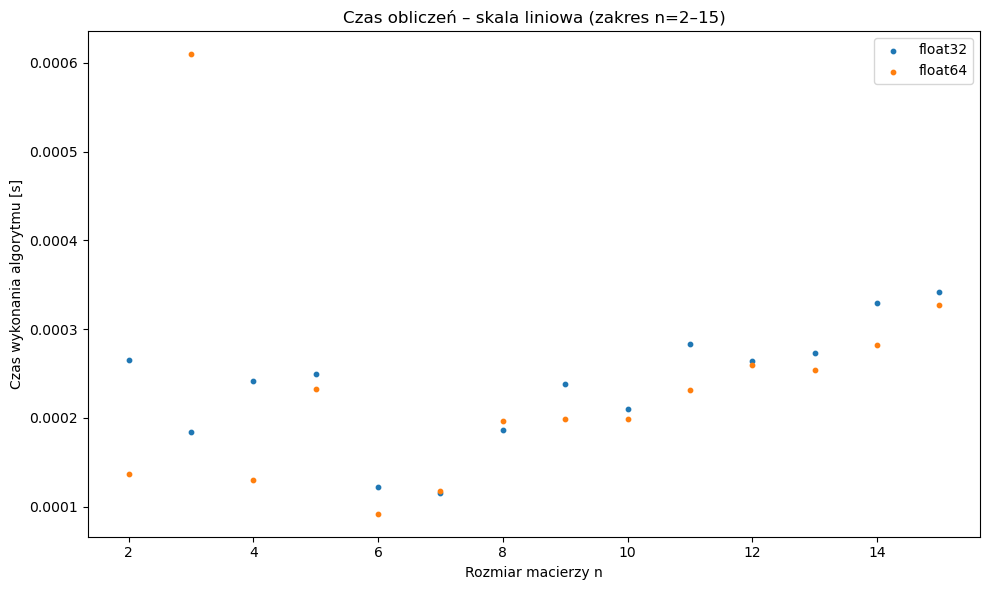

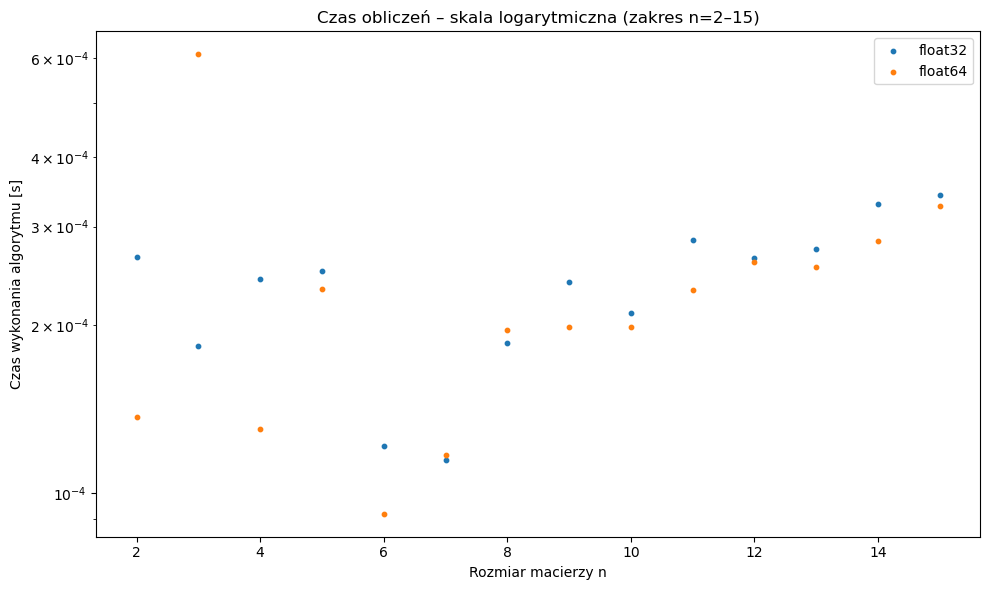

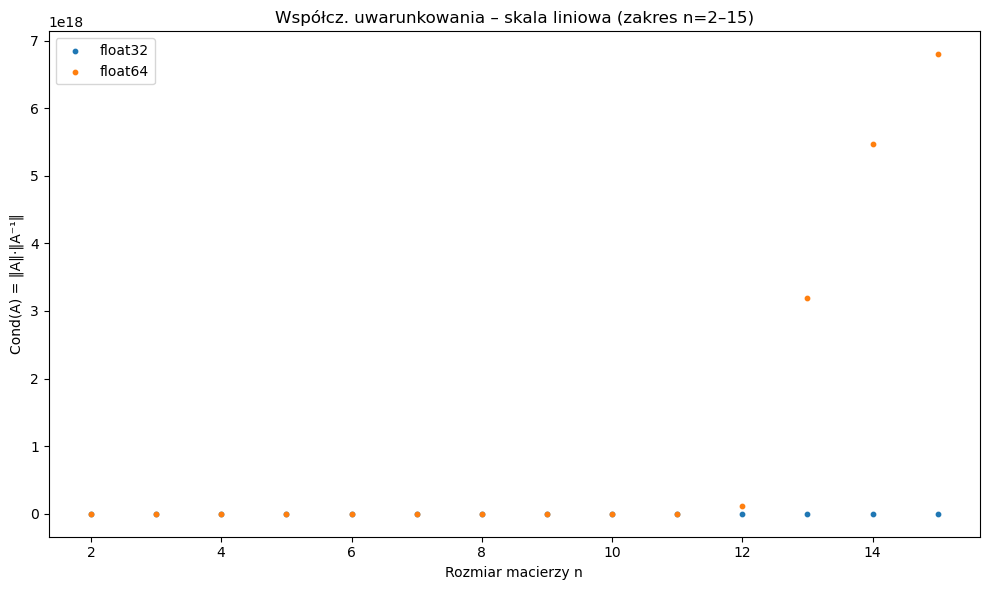

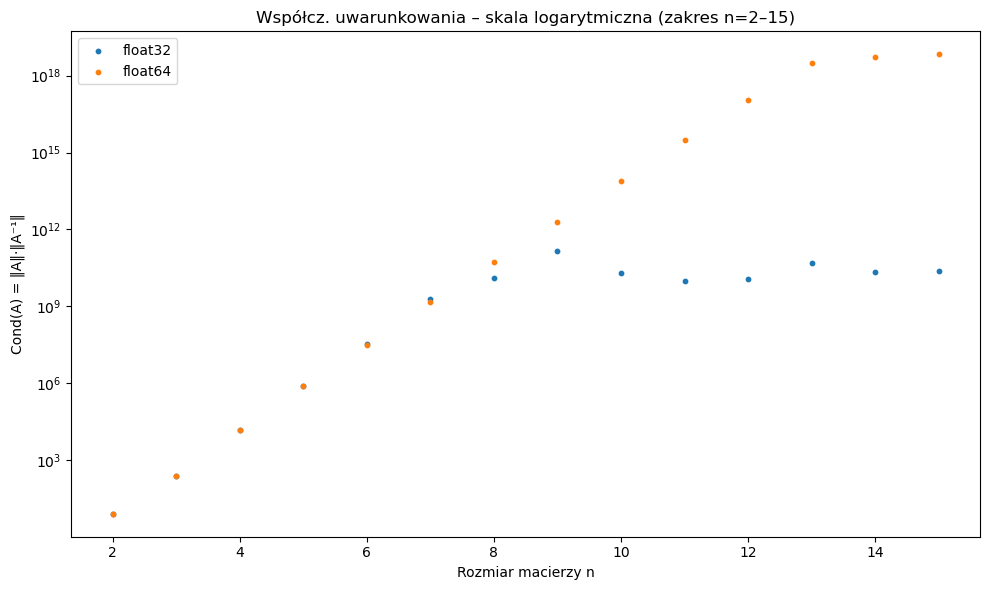

In [10]:
for metric in title_map:
    plot_with_range(wide1, metric, scale='linear', n_min=2, n_max=15)
    plot_with_range(wide1, metric, scale='log',    n_min=2, n_max=15)

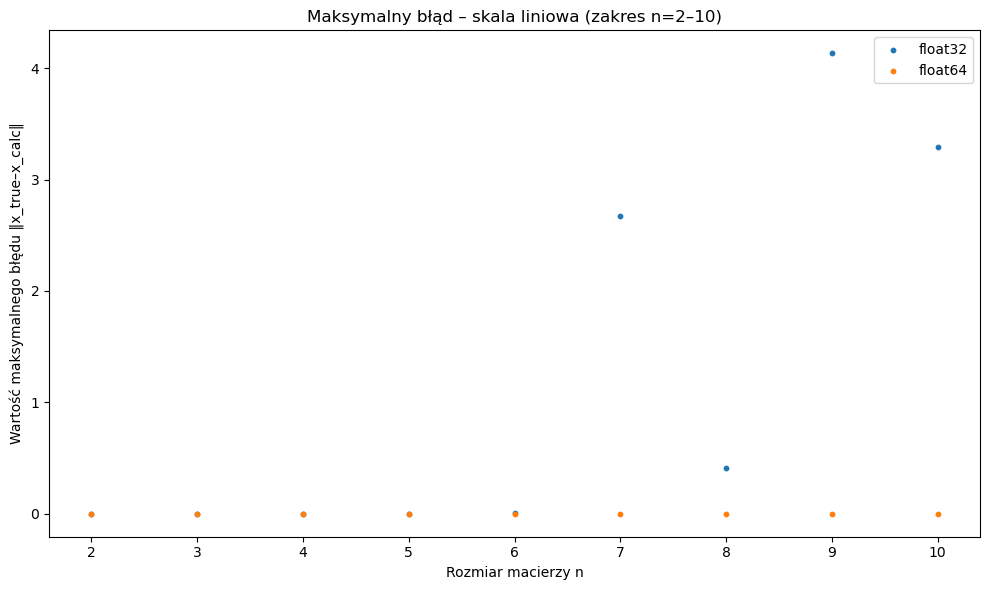

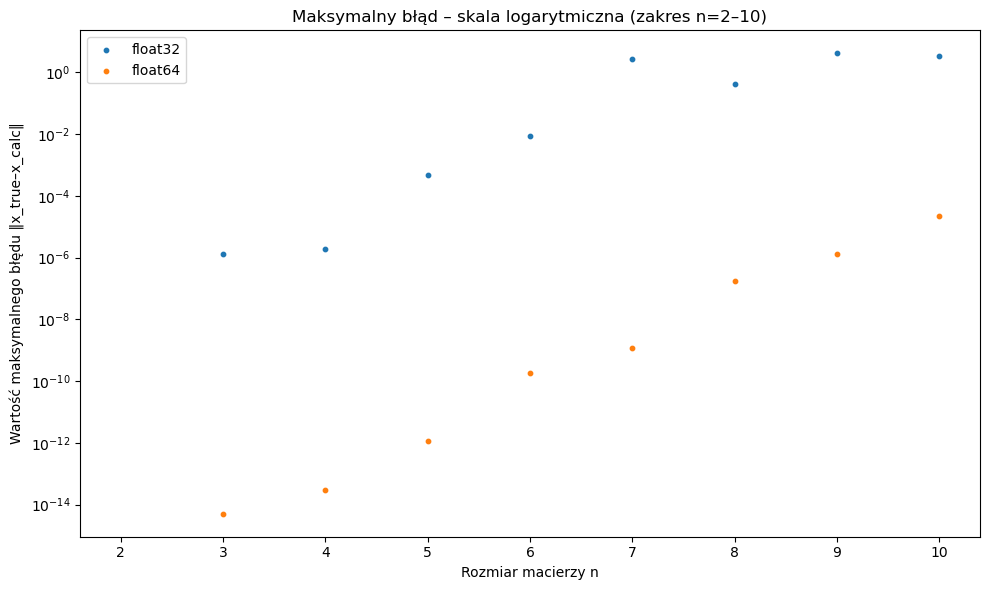

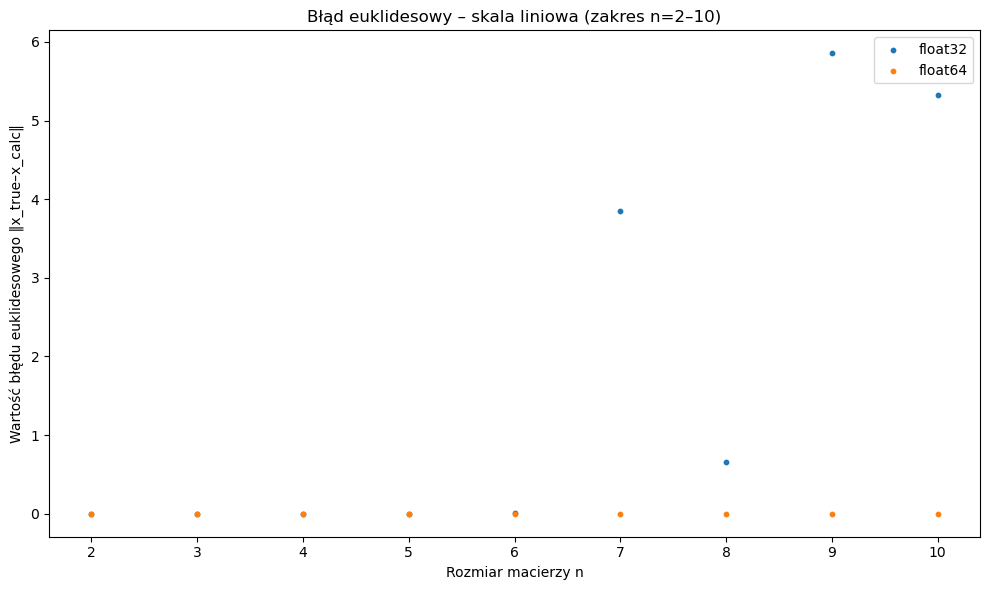

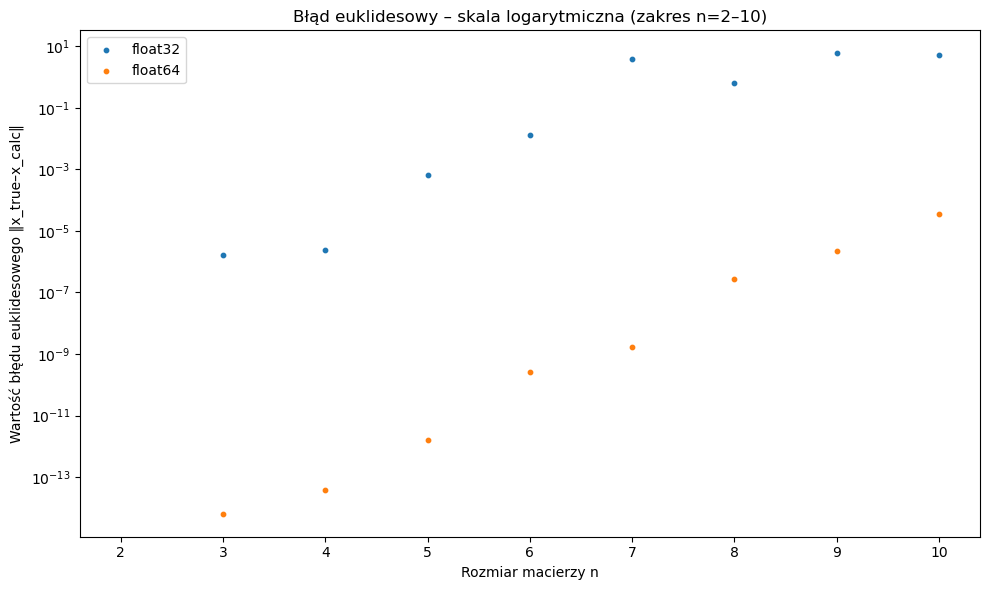

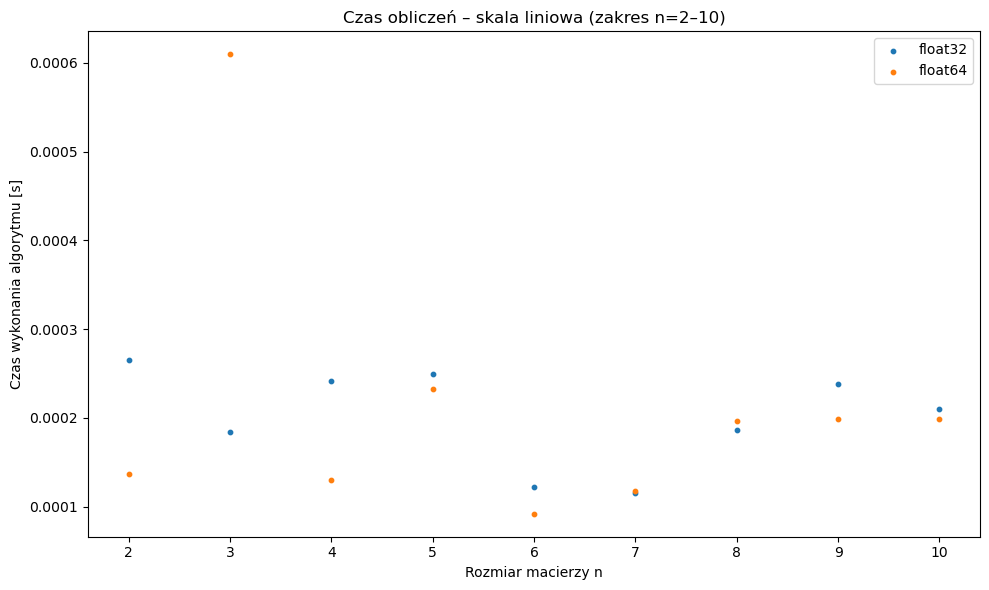

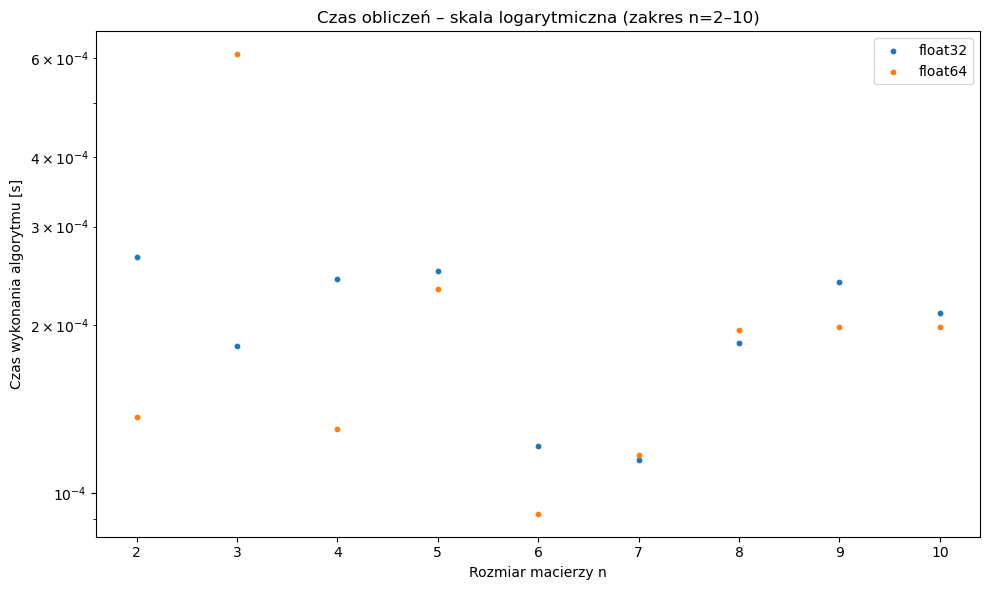

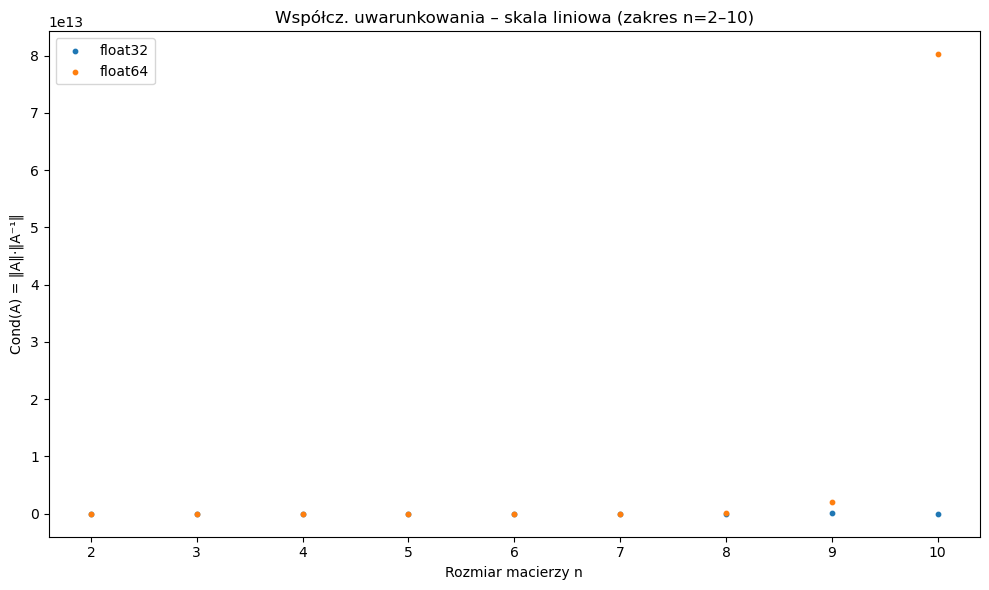

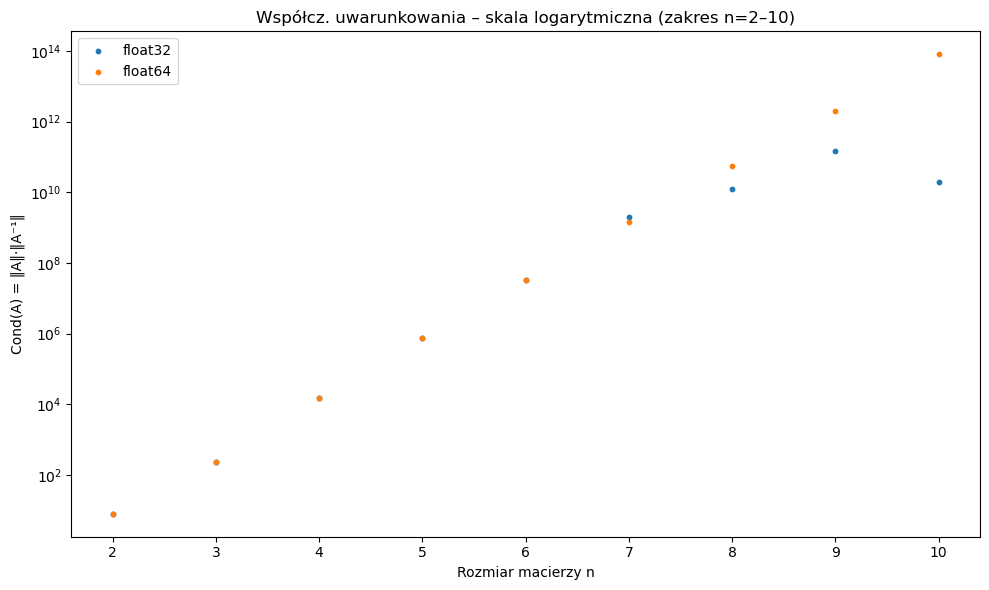

In [11]:
for metric in title_map: 
    plot_with_range(wide1, metric, scale='linear', n_min=2, n_max=10)
    plot_with_range(wide1, metric, scale='log',    n_min=2, n_max=10)

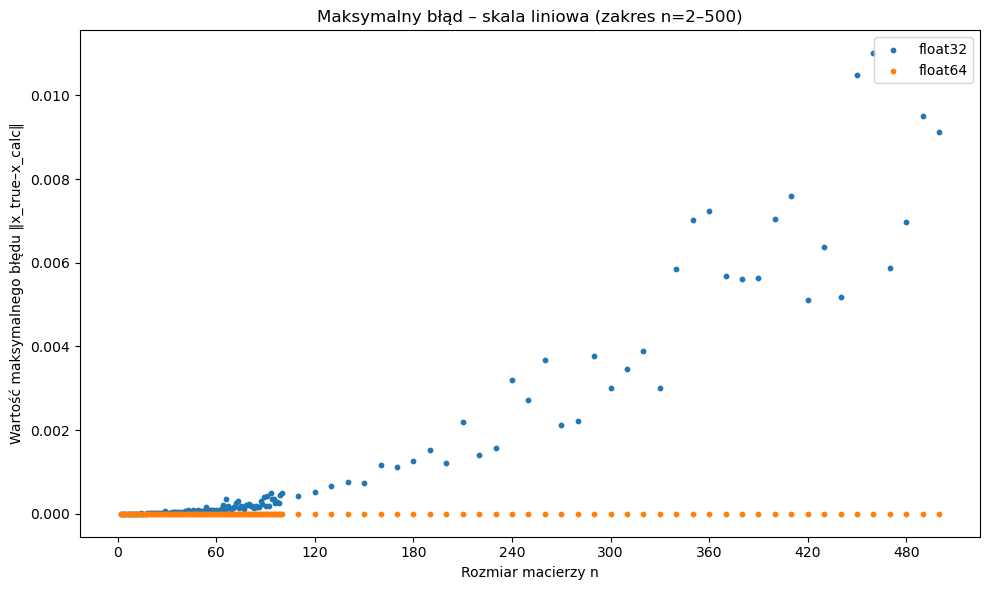

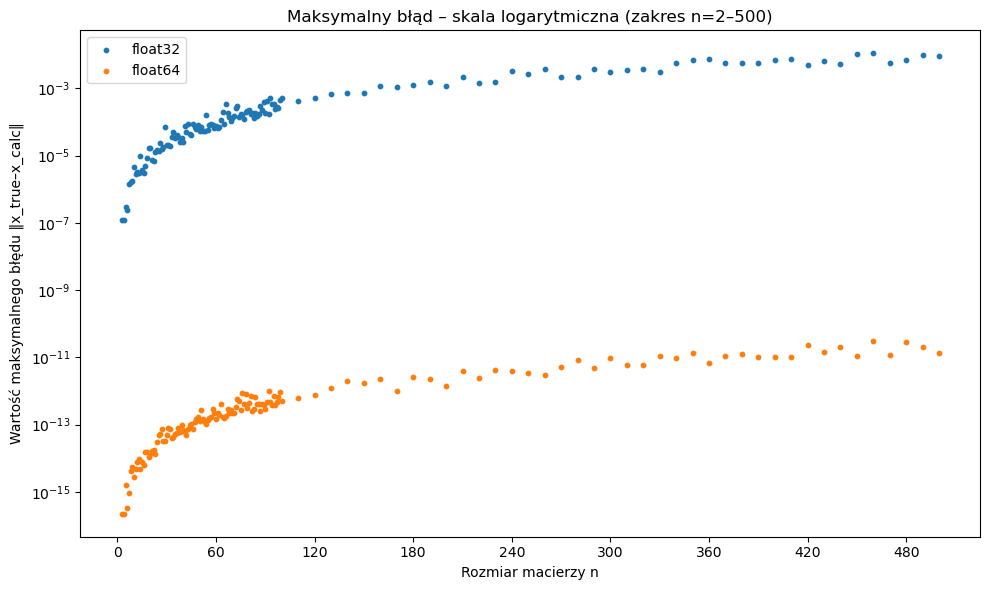

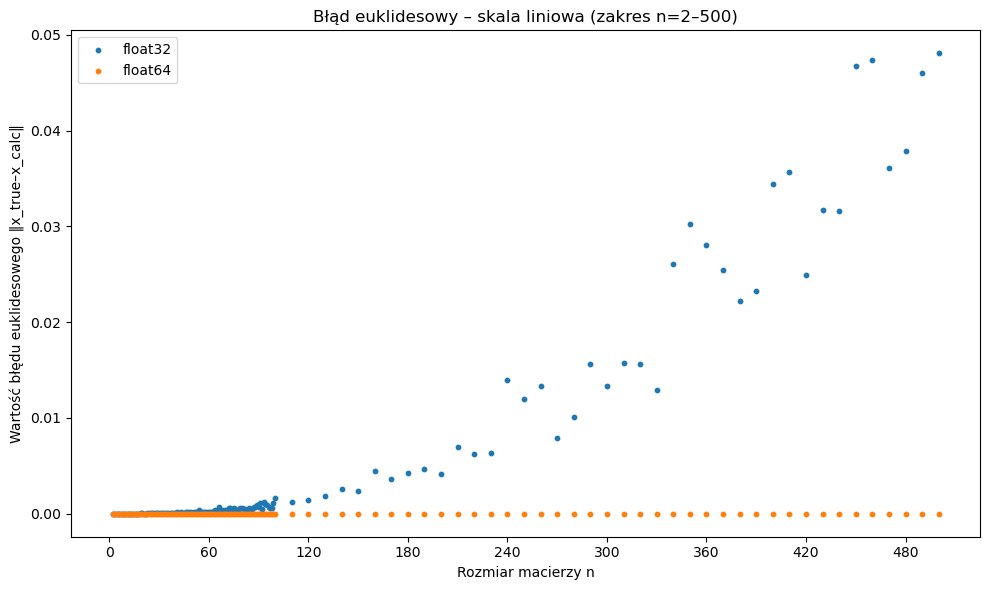

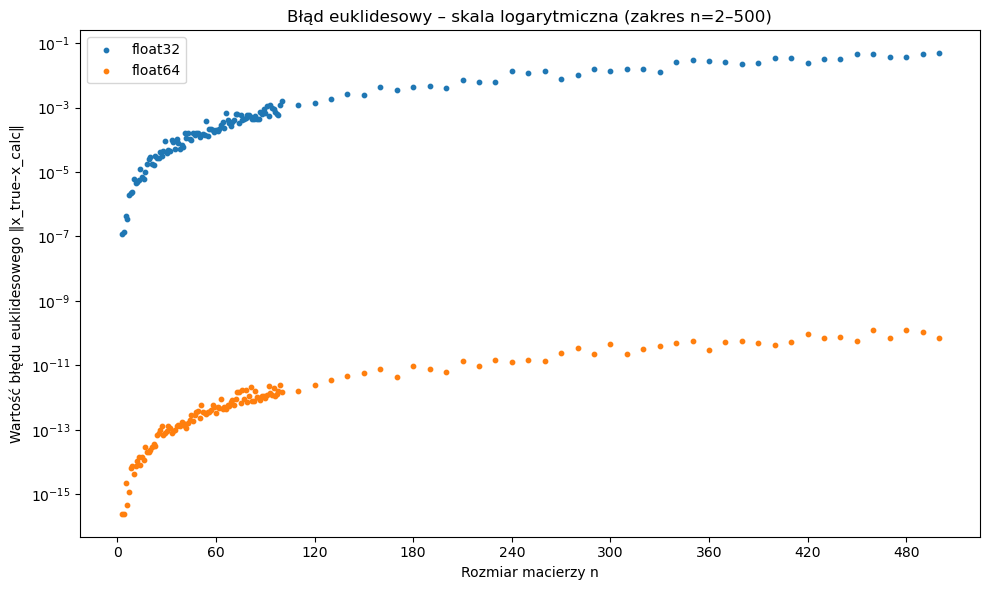

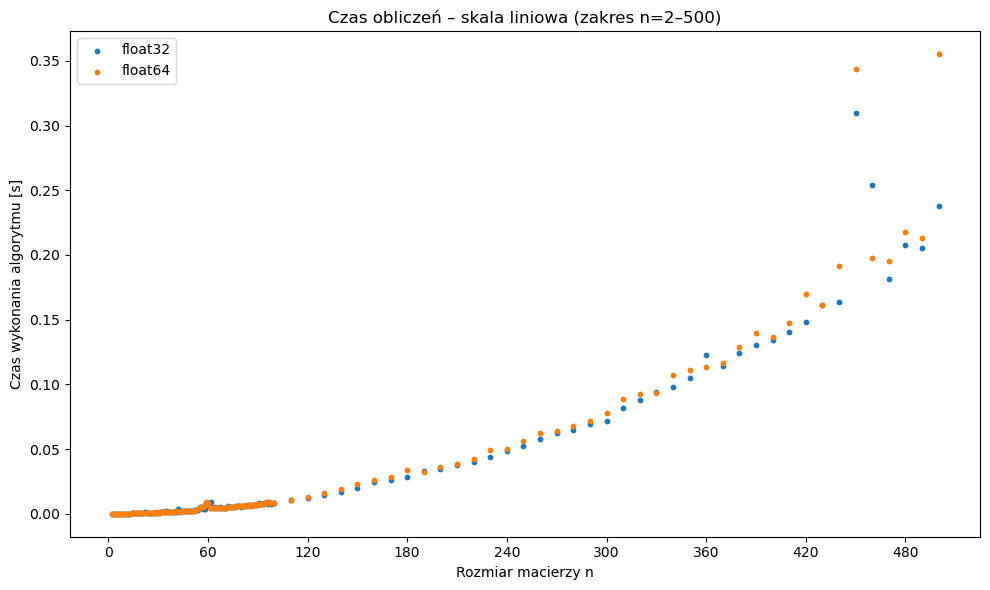

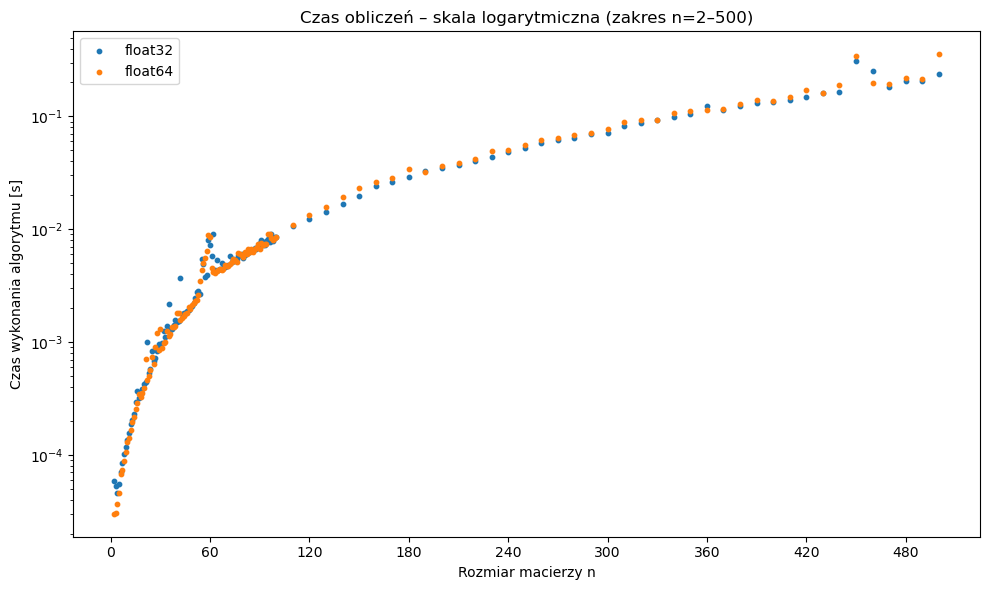

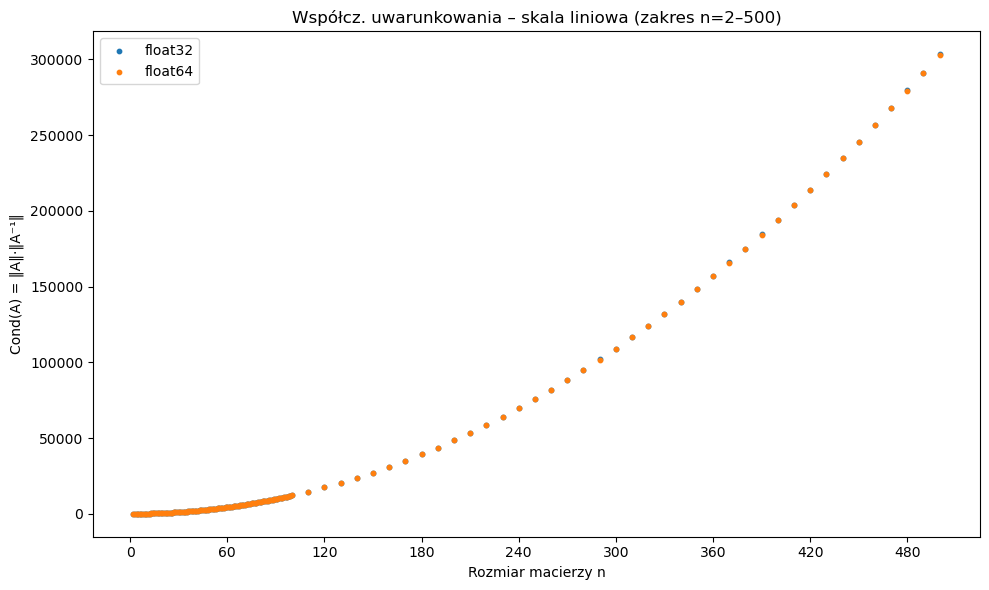

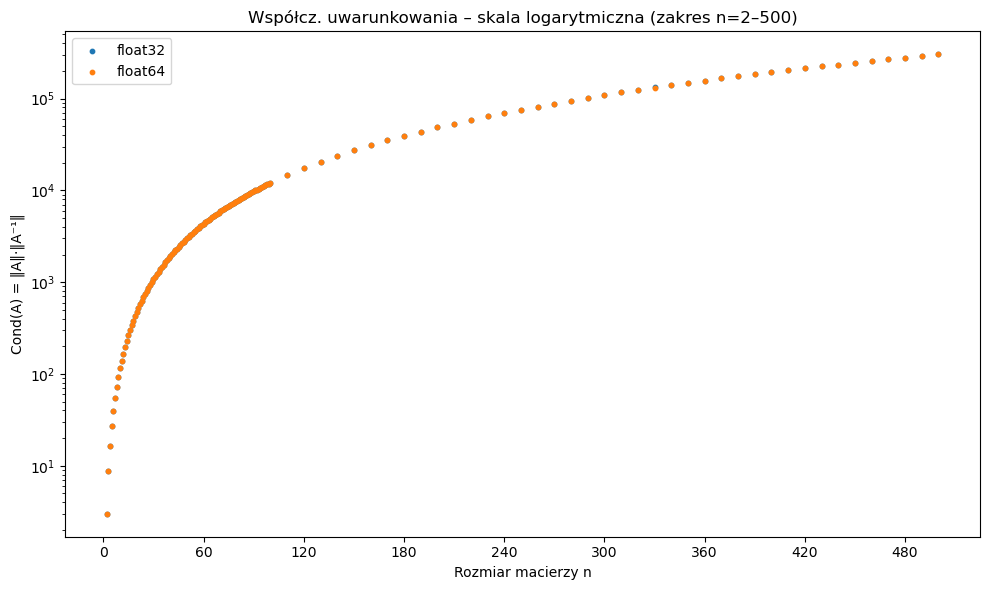

In [12]:
for metric in title_map:
    plot_with_range(wide2, metric, scale='linear', n_min=2, n_max=500)
    plot_with_range(wide2, metric, scale='log',    n_min=2, n_max=500)

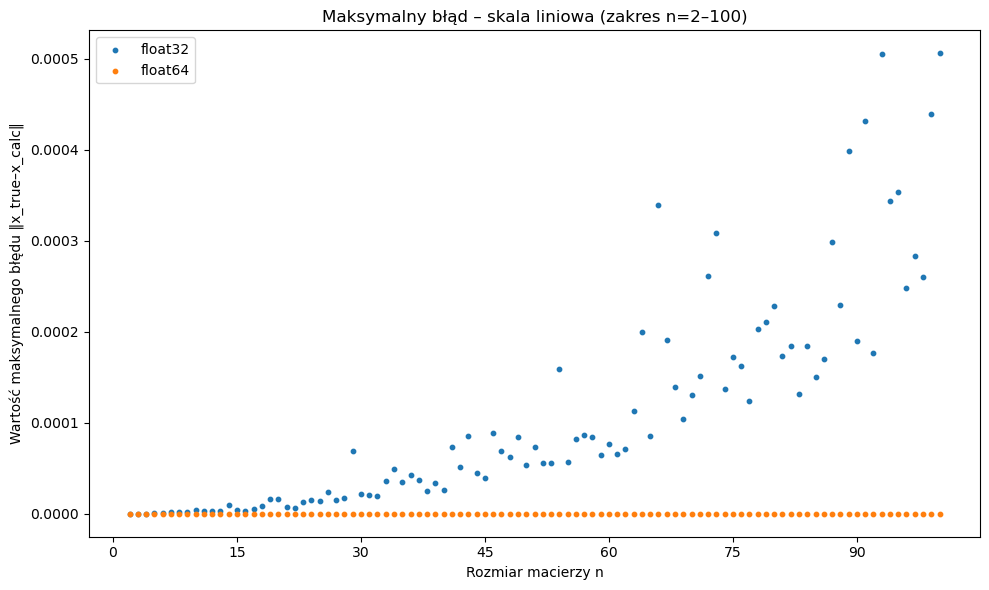

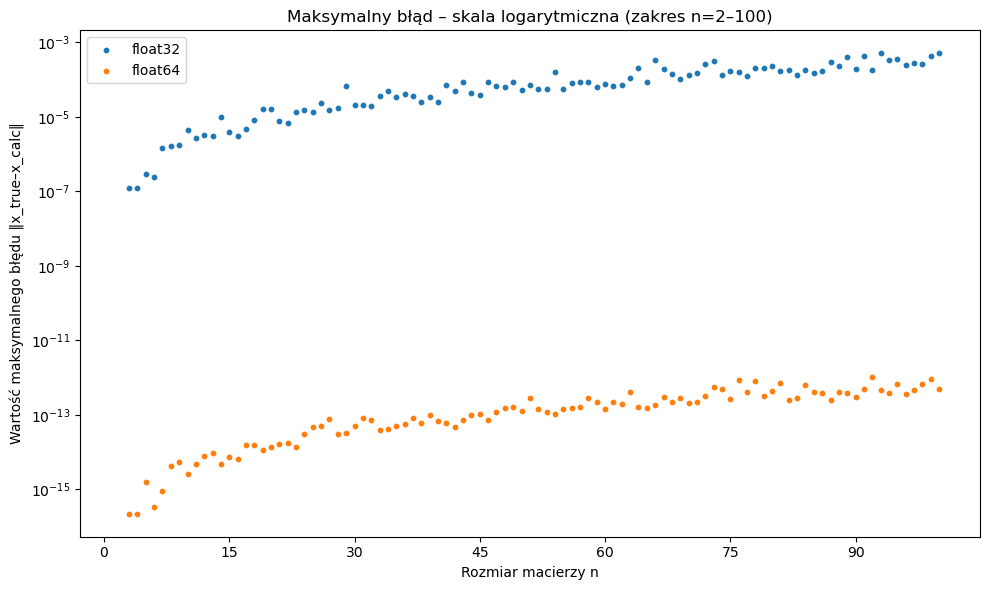

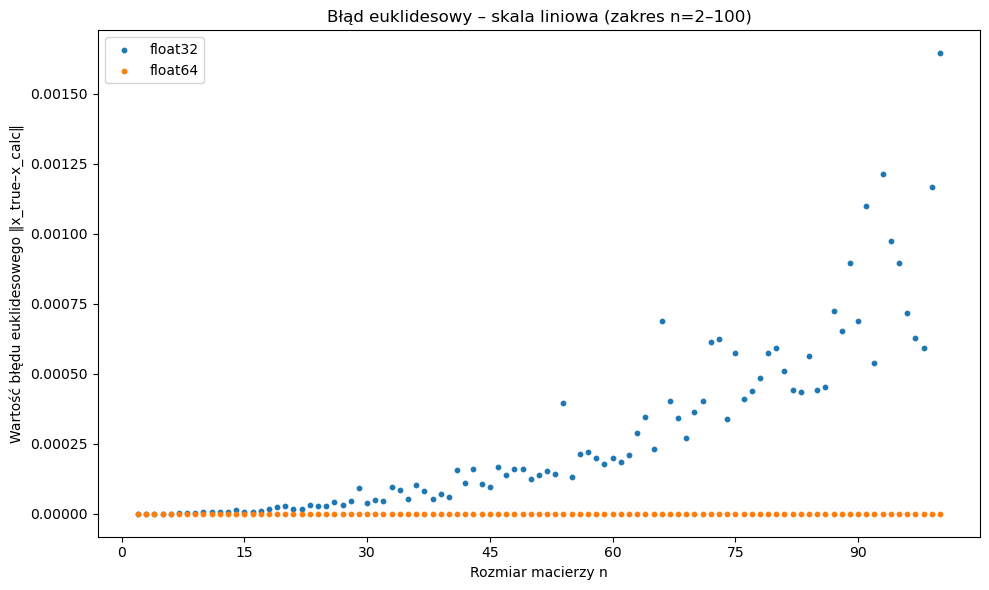

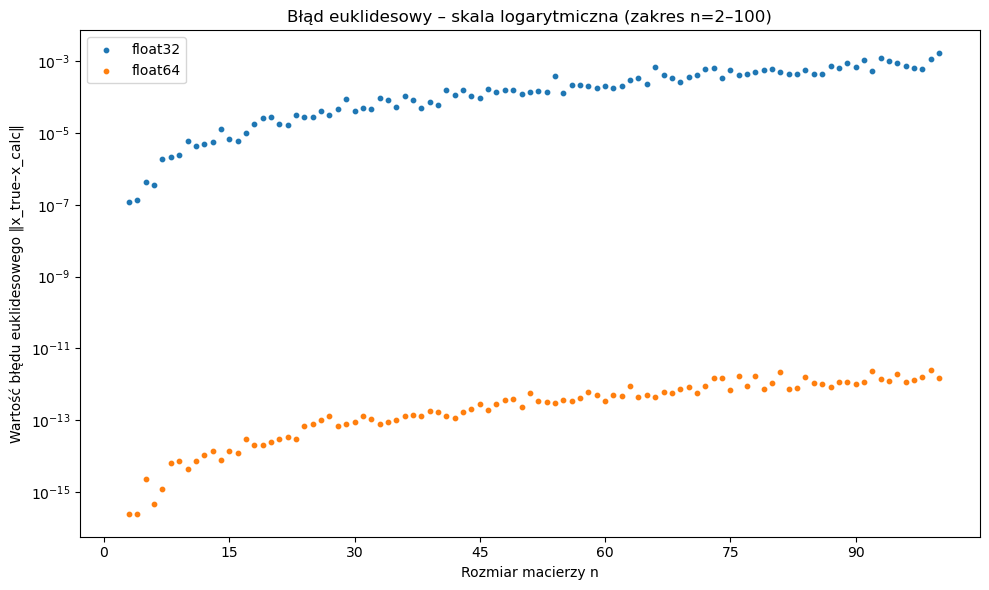

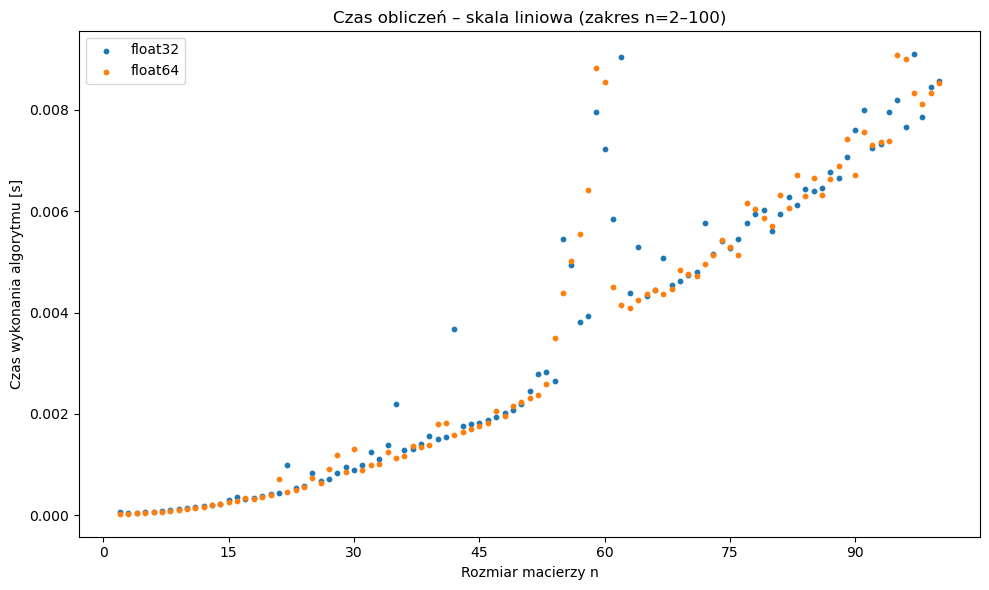

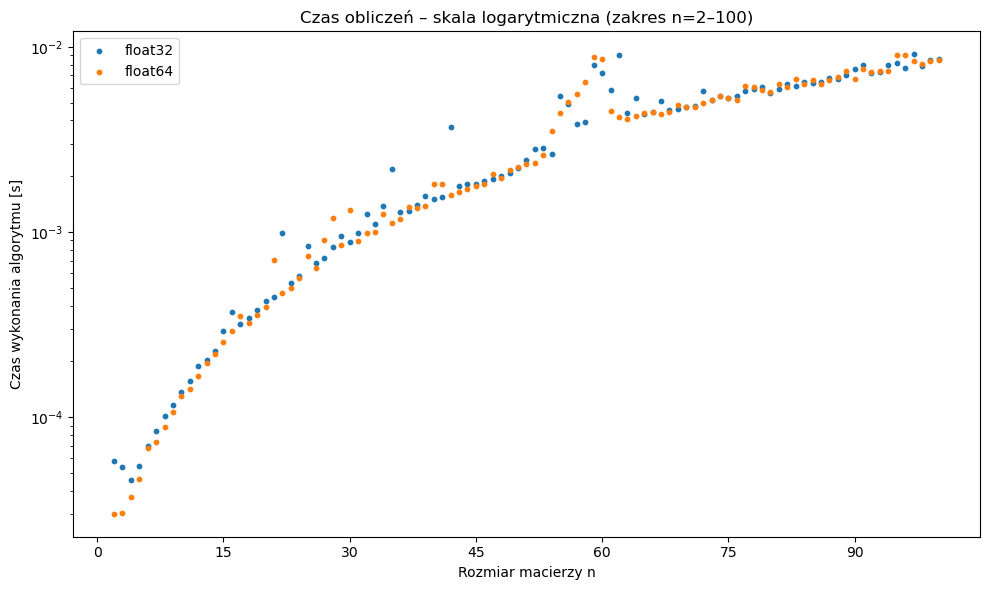

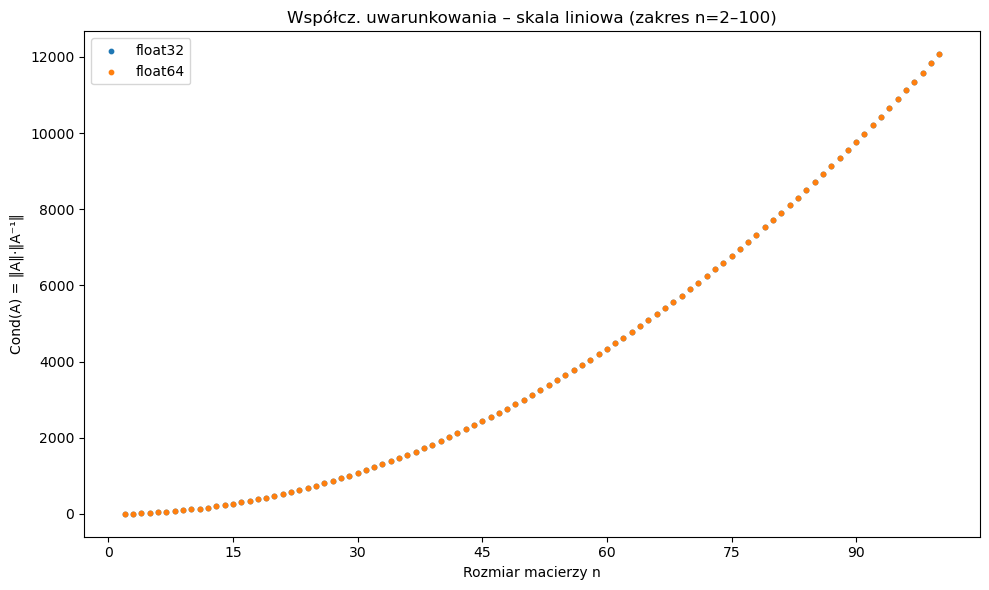

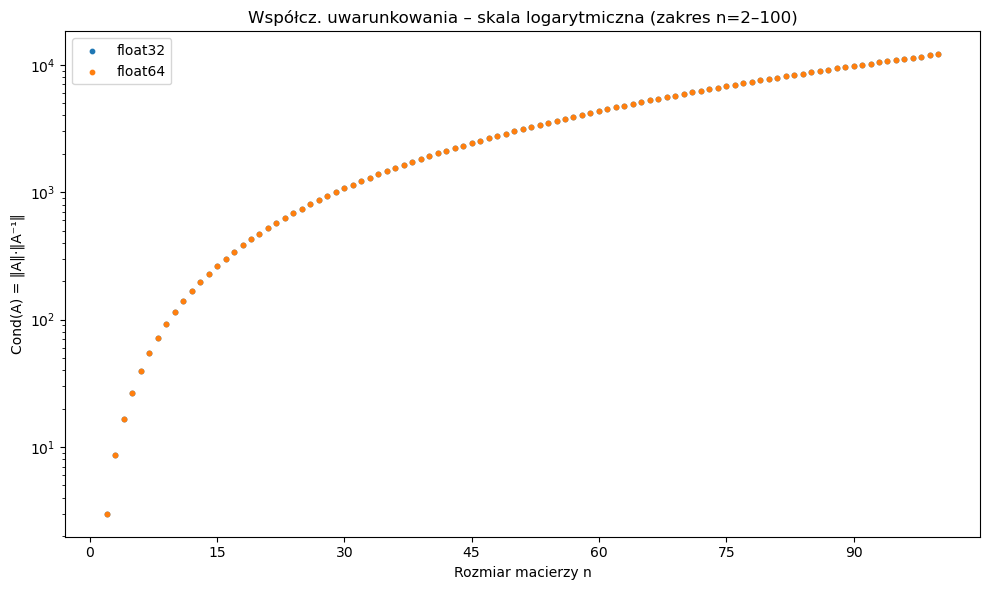

In [13]:
for metric in title_map:
    plot_with_range(wide2, metric, scale='linear', n_min=2, n_max=100)
    plot_with_range(wide2, metric, scale='log',    n_min=2, n_max=100)

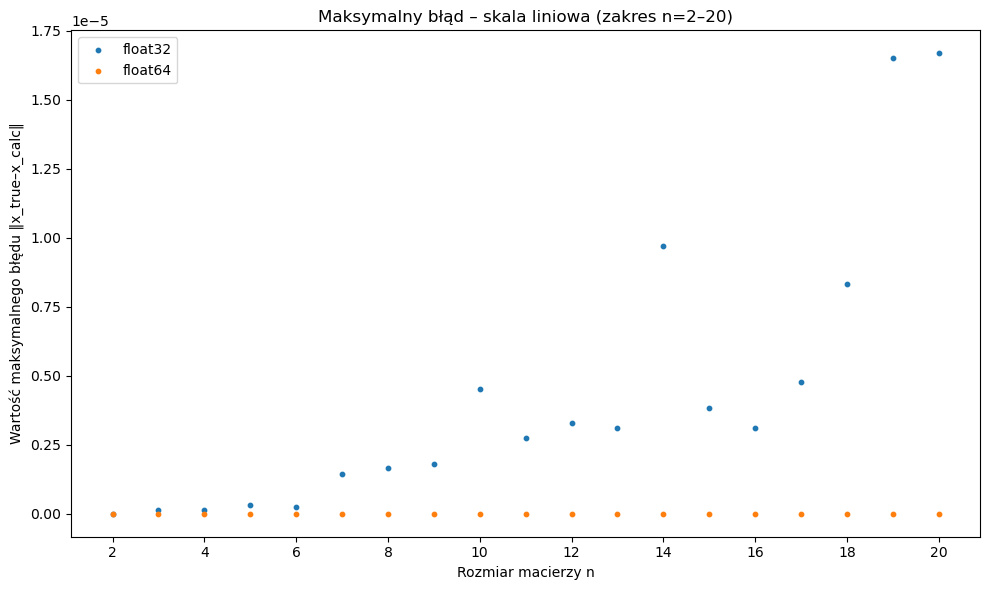

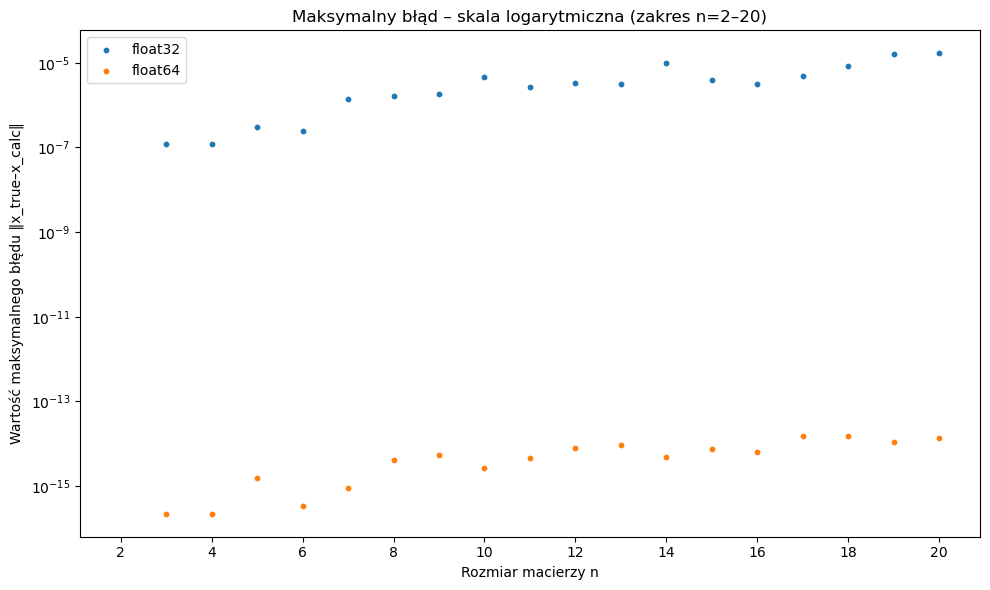

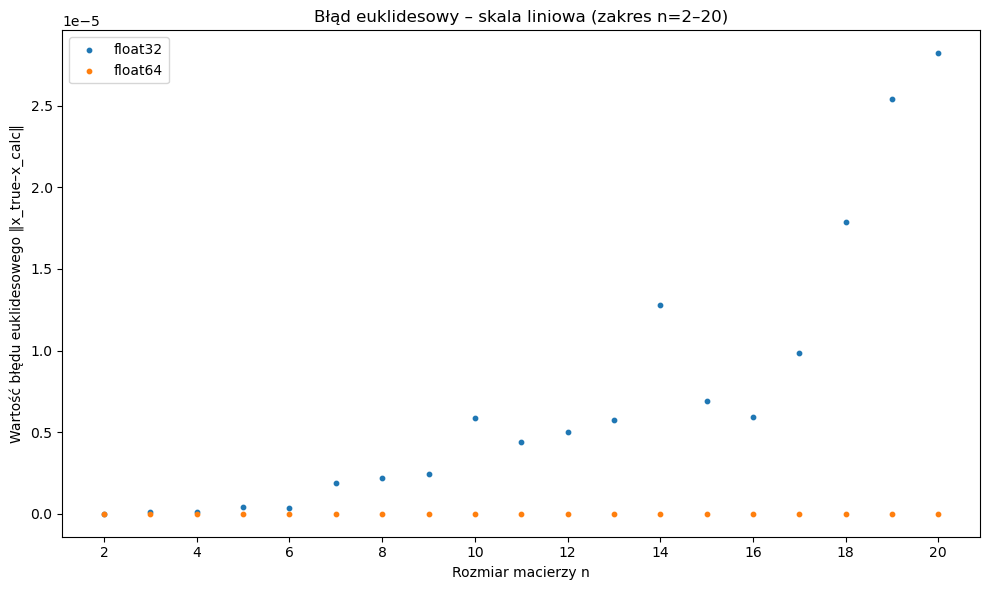

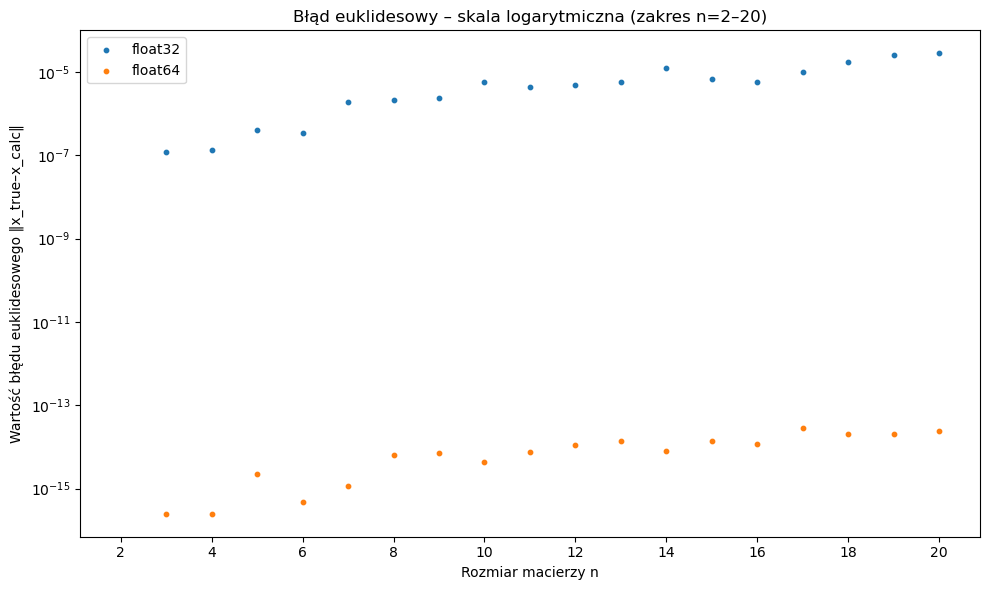

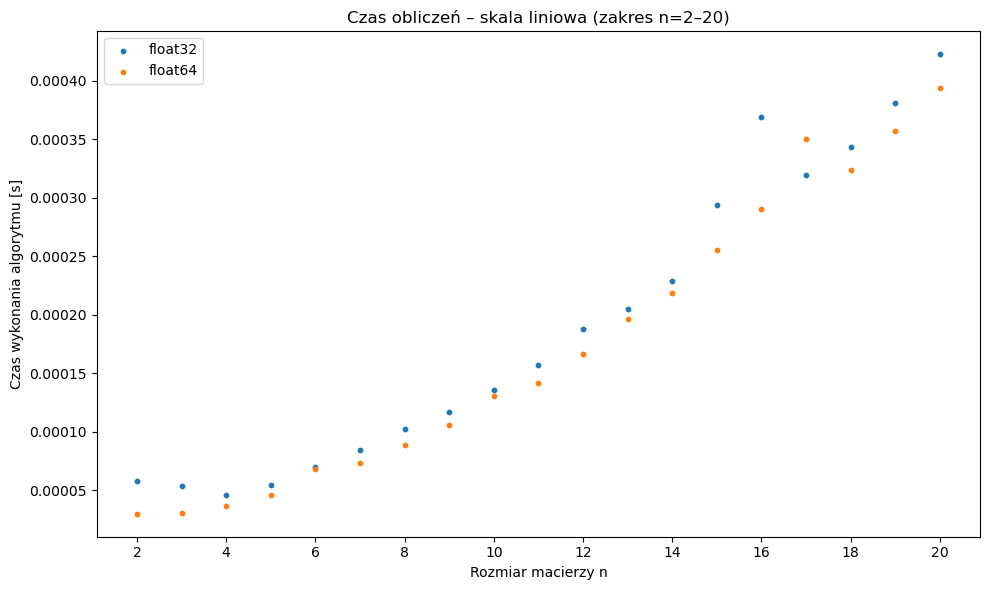

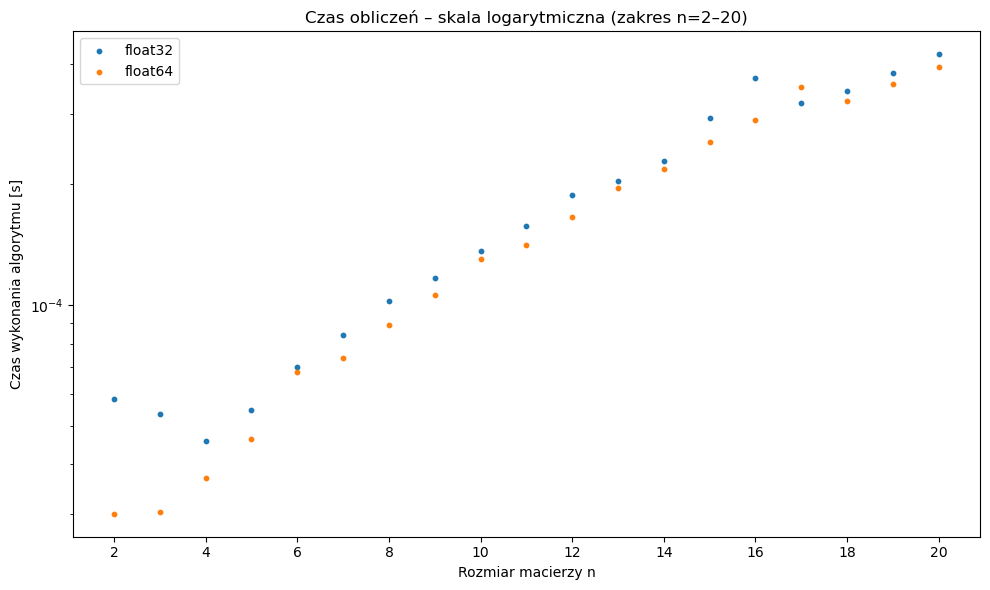

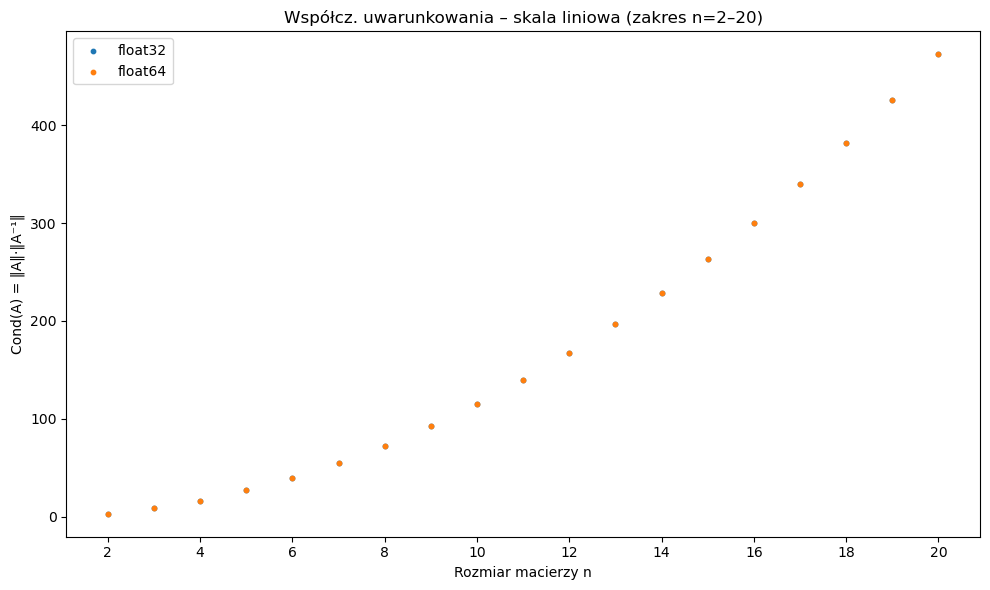

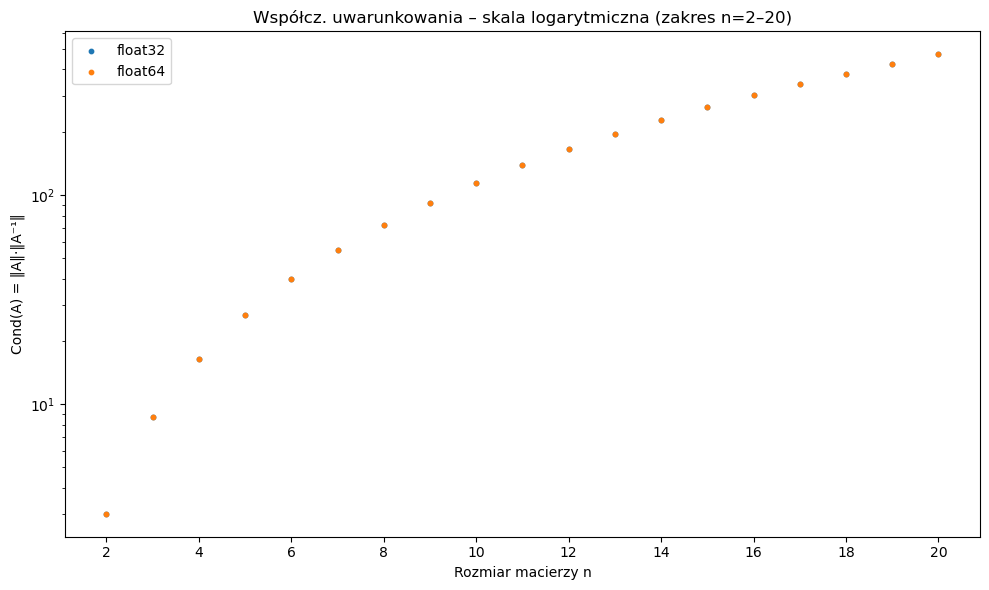

In [14]:
for metric in title_map:
    plot_with_range(wide2, metric, scale='linear', n_min=2, n_max=20)
    plot_with_range(wide2, metric, scale='log',    n_min=2, n_max=20)

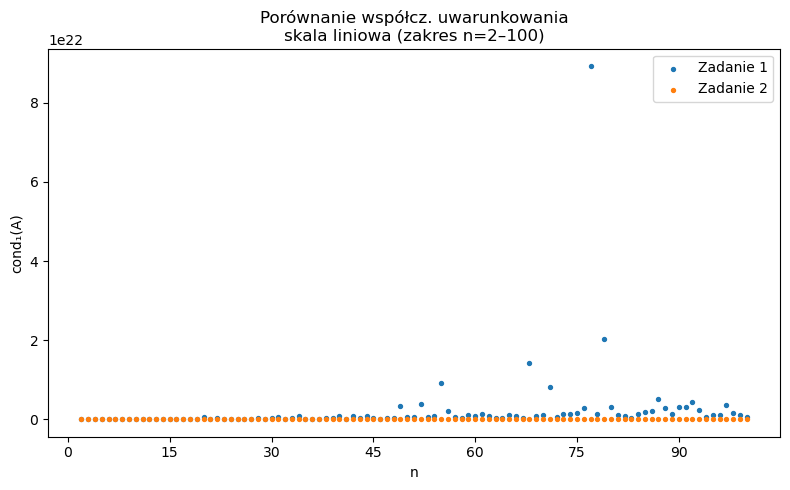

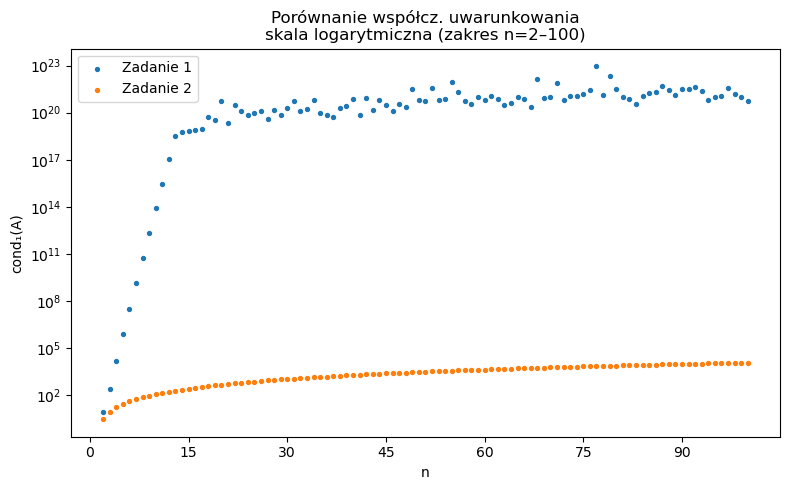

In [15]:
w1 = wide1[wide1['n'] <= 100]
w2 = wide2[wide2['n'] <= 100]

def compare_condition(w1, w2, scale='linear'):
    plt.figure(figsize=(8,5))
    plt.scatter(w1['n'], w1['cond_1_float64'], 
                label='Zadanie 1', marker='o', s=8)
    plt.scatter(w2['n'], w2['cond_1_float64'], 
                label='Zadanie 2', marker='o', s=8)
    if scale=='log':
        plt.yscale('log')
    plt.title(
        "Porównanie współcz. uwarunkowania\n"
        + ("skala logarytmiczna" if scale=='log' else "skala liniowa")
        + " (zakres n=2–100)"
    )
    plt.xlabel('n')
    plt.ylabel('cond₁(A)')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

# rysujemy:
compare_condition(w1, w2, scale='linear')
compare_condition(w1, w2, scale='log')

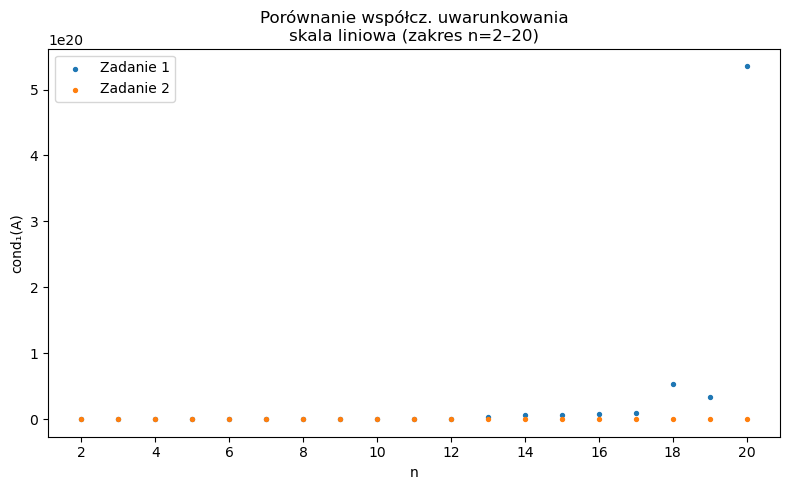

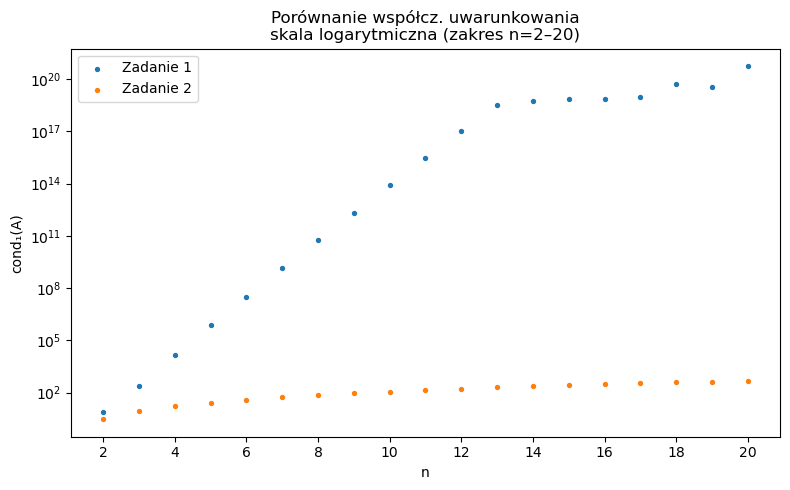

In [16]:
w1 = wide1[wide1['n'] <= 20]
w2 = wide2[wide2['n'] <= 20]

def compare_condition(w1, w2, scale='linear'):
    plt.figure(figsize=(8,5))
    plt.scatter(w1['n'], w1['cond_1_float64'], 
                label='Zadanie 1', marker='o', s=8)
    plt.scatter(w2['n'], w2['cond_1_float64'], 
                label='Zadanie 2', marker='o', s=8)
    if scale=='log':
        plt.yscale('log')
    plt.title(
        "Porównanie współcz. uwarunkowania\n"
        + ("skala logarytmiczna" if scale=='log' else "skala liniowa")
        + " (zakres n=2–20)"
    )
    plt.xlabel('n')
    plt.ylabel('cond₁(A)')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

# rysujemy:
compare_condition(w1, w2, scale='linear')
compare_condition(w1, w2, scale='log')

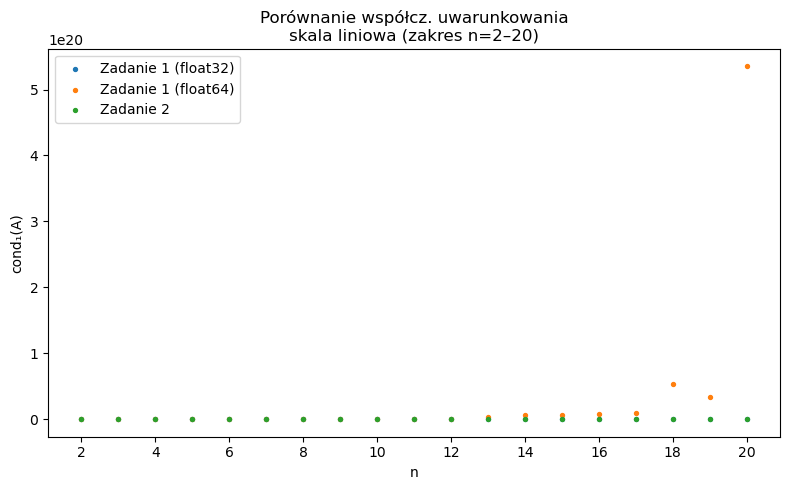

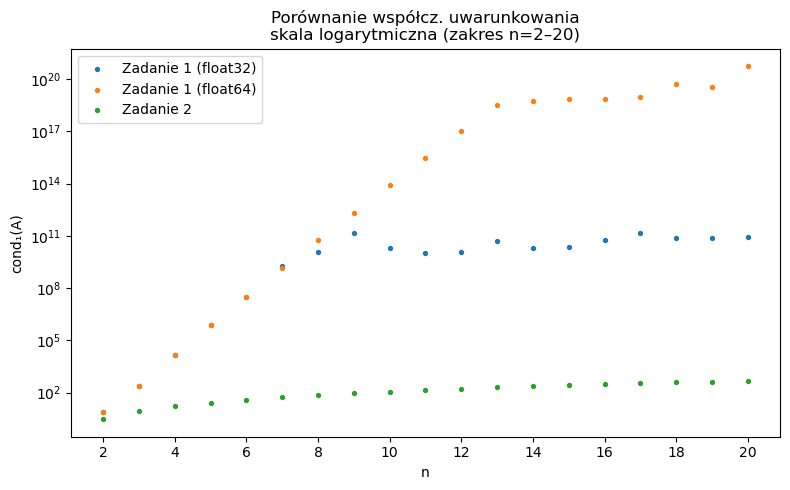

In [17]:
def compare_condition_three(w1, w2, scale='linear'):
    plt.figure(figsize=(8,5))
   
    plt.scatter(w1['n'], w1['cond_1_float32'], 
                label='Zadanie 1 (float32)', marker='o', s=8)
    plt.scatter(w1['n'], w1['cond_1_float64'], 
                label='Zadanie 1 (float64)', marker='o', s=8)
    plt.scatter(w2['n'], w2['cond_1_float64'], 
                label='Zadanie 2', marker='o', s=8)
    if scale == 'log':
        plt.yscale('log')
    plt.title(
        "Porównanie współcz. uwarunkowania\n"
        + ("skala logarytmiczna" if scale == 'log' else "skala liniowa")
        + " (zakres n=2–20)"
    )
    plt.xlabel('n')
    plt.ylabel('cond₁(A)')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()
compare_condition_three(w1, w2, scale='linear')
compare_condition_three(w1, w2, scale='log')

In [ ]:
# #df to tex
# wide1.to_latex('task1_results_wide.tex', index=False)
# wide2.to_latex('task2_results_wide.tex', index=False)